In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from tqdm.notebook import tqdm
from pathlib import Path
import argparse
import math
from scipy import stats
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sys.path.insert(0, '..')

from util.evaluation import load_paris_results, load_ricseq_splash_mario_results, map_signal_to_sigmoid_range, balance_df, plot_histogram_01, remove_outliers, log_func, load_res_and_tools, plot_all_model_auc, plot_all_model_auc, obtain_all_model_auc, obtain_subset_from_task, plot_results_of_all_models, obtain_sr_nosr, make_plot_kde_and_test_difference
from util.plot_utils import plot_results_based_on_treshold_for_all_models, plot_results_based_on_topbottom_for_all_models, plot_results_how_many_repeats_in_pred_pos_for_all_models
# %load_ext autoreload
# %autoreload 2

from config import *
from models.nt_classifier import build as build_model 
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
    
external_dataset_dir = os.path.join(dataset_files_dir, 'external_dataset', '500_test_tables')

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
datasets = ['paris', 'ricseq', 'splash', 'mario']
tools = ['priblast', 'risearch2'] #['priblast', 'RNAup', 'RNAplex', 'RNAhybrid', 'rnacofold', 'risearch2', 'assa']
energy_columns = tools + ['E_norm']

#ARGS for paris
SPECIE_PARIS = 'human'
PARIS_HQ = False
PARIS_HQ_THRESHOLD = 35
MIN_N_READS_RICSEQ = 3

#ARGS for splash, ricseq, mario


args_datasets = {'paris':
                 {'only_test' : np.nan, #uneuseful for paris
                  'exclude_train_genes' : np.nan, #uneuseful for paris
                  'exclude_paris_genes' : np.nan, #uneuseful for paris
                  'exclude_paris_couples' : np.nan, #uneuseful for paris
                  'filter_hq_ricseq' : np.nan, #uneuseful for paris
                  'MIN_N_READS_RICSEQ' : np.nan, #uneuseful for paris
                  'SPECIE_PARIS' : SPECIE_PARIS,
                  'PARIS_HQ':PARIS_HQ,
                  'PARIS_HQ_THRESHOLD':PARIS_HQ_THRESHOLD,
                 }, 
                 'ricseq': 
                 {'only_test' : False,
                  'exclude_train_genes' : False,
                  'exclude_paris_genes' : False,
                  'exclude_paris_couples' : True,
                  'filter_hq_ricseq' : False,
                  'MIN_N_READS_RICSEQ' : MIN_N_READS_RICSEQ,
                  'SPECIE_PARIS' : np.nan, #uneuseful for ricseq
                  'PARIS_HQ':np.nan, #uneuseful for ricseq
                  'PARIS_HQ_THRESHOLD':np.nan, #uneuseful for ricseq
                 },
                 'splash': 
                 {'only_test' : True,
                  'exclude_train_genes' : False,
                  'exclude_paris_genes' : False,
                  'exclude_paris_couples' : True,
                  'filter_hq_ricseq' : False, #uneuseful for splash
                  'MIN_N_READS_RICSEQ' : np.nan, #uneuseful for splash
                  'SPECIE_PARIS' : np.nan, #uneuseful for splash
                  'PARIS_HQ':np.nan, #uneuseful for splash
                  'PARIS_HQ_THRESHOLD':np.nan, #uneuseful for splash
                 },
                'mario': 
                 {'only_test' : False,
                  'exclude_train_genes' : False,
                  'exclude_paris_genes' : False,
                  'exclude_paris_couples' : True,
                  'filter_hq_ricseq' : False, #uneuseful for mario
                  'MIN_N_READS_RICSEQ' : np.nan,  #uneuseful for mario
                  'SPECIE_PARIS' : np.nan, #uneuseful for mario
                  'PARIS_HQ':np.nan, #uneuseful for mario
                  'PARIS_HQ_THRESHOLD':np.nan, #uneuseful for mario
                 },
}

args_datasets['test'] = args_datasets['paris'] #sometimes I want to call it 'test'

In [28]:
nt_models = ['all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039_NOWENHNokSN_PARISFINETUNINGtrainhqSPLASHval0043', 
             'all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_splashPARISFINETUNINGtrainhqRICSEQval0060_NOWENHNokSN_splashPARISFINETUNINGtrainhqRICSEQval0083',
             'all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_PARISFINETUNINGtrainhqRICSEQval0055_NOWENHNokSN_parisfinetuningTRAINHQhumanRICSEQval0079',
            ]

In [29]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', nt_models[0]) 
#'less_samples_in_train',
#all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151
# all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151_trainall0198

DATASET: paris
easypos_smartneg


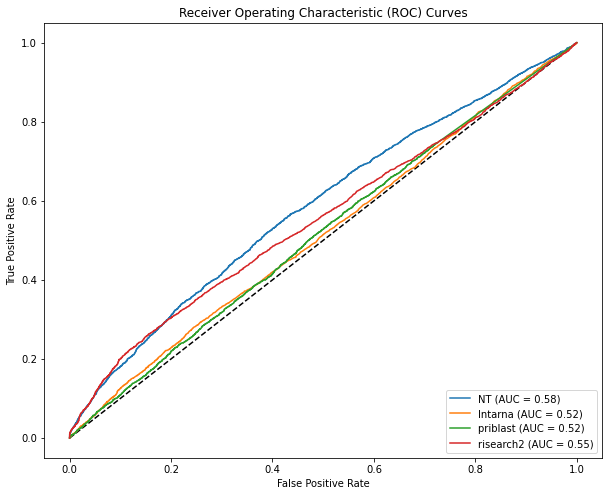

ephnen


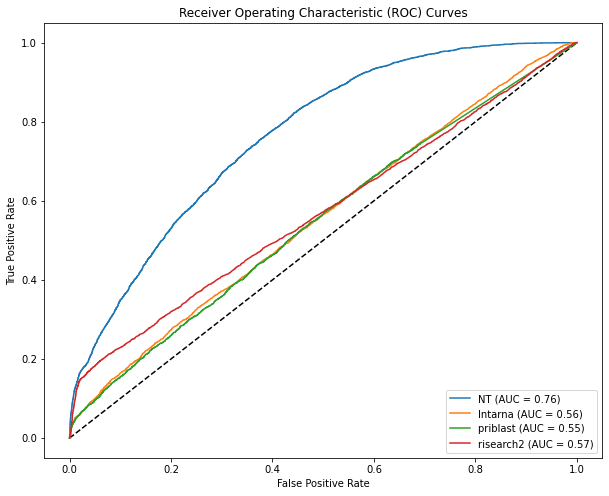

enhn500


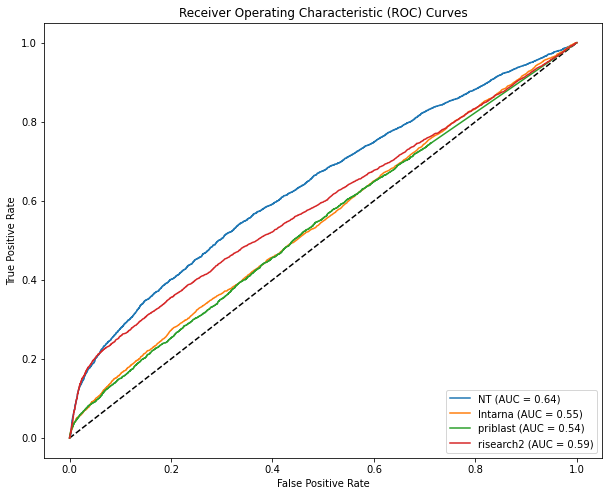




# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
DATASET: ricseq
easypos_smartneg


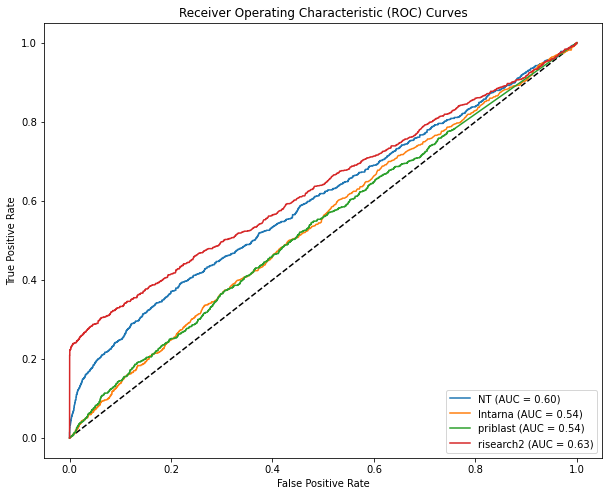

ephnen


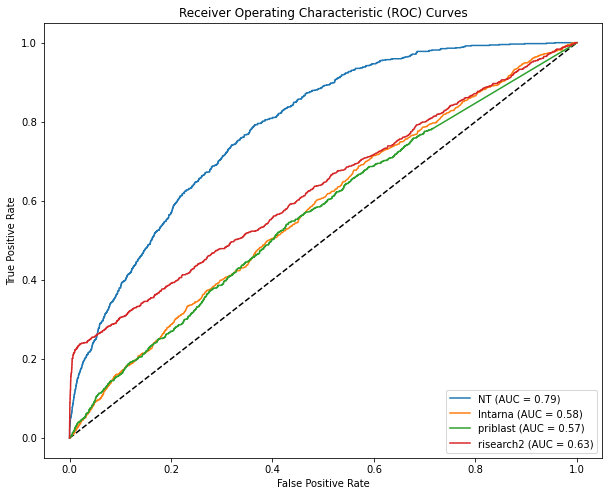

enhn500


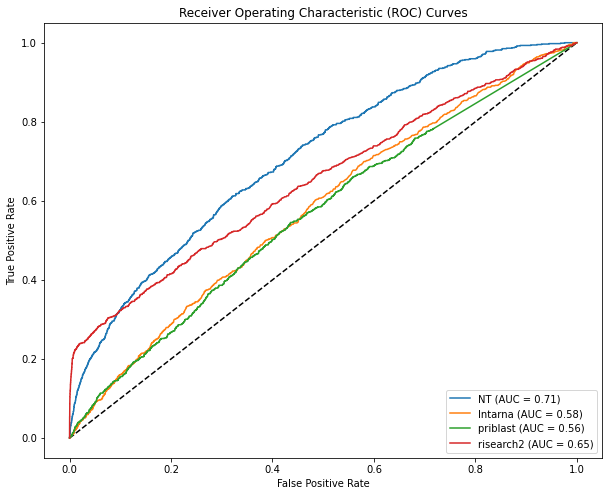




# excluded couples:  12
# excluded couples:  12
# excluded couples:  12
DATASET: splash
easypos_smartneg


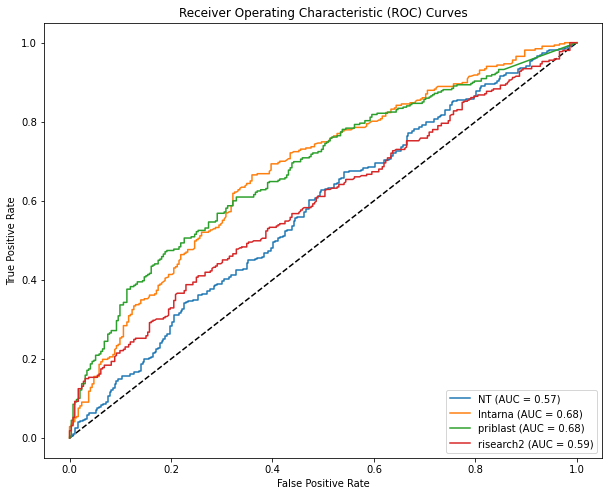

ephnen


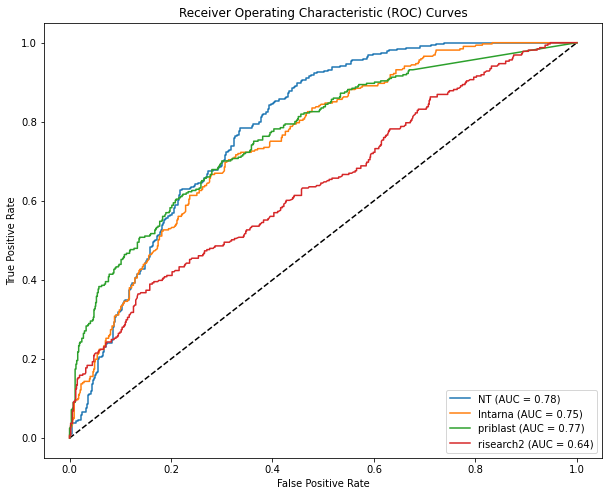

enhn500


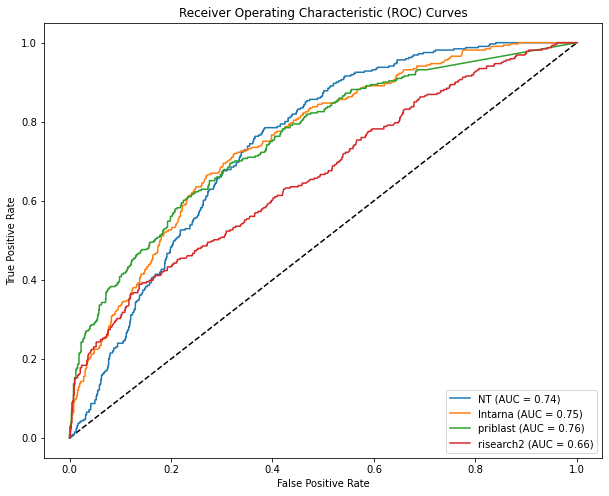




# excluded couples:  4
# excluded couples:  4
# excluded couples:  4
DATASET: mario
easypos_smartneg


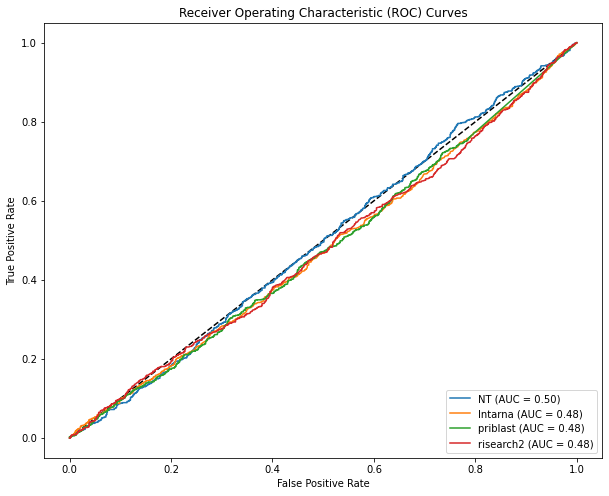

ephnen


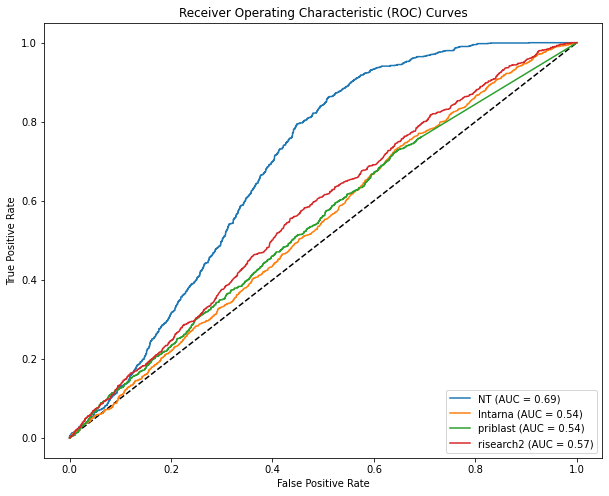

enhn500


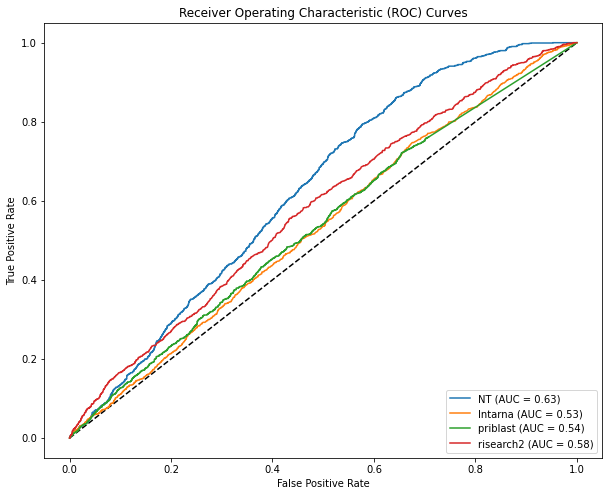

In [30]:
dfs = []

for dataset in datasets:
    how = dataset if dataset != 'paris' else 'test'
    res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             args_datasets[how]['MIN_N_READS_RICSEQ'], 
                             SPECIE_PARIS,
                             args_datasets[how]['PARIS_HQ'],
                             args_datasets[how]['PARIS_HQ_THRESHOLD'],
                             False,)
    easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
    easypos_smartneg = balance_df(easypos_smartneg)
    dfs.append(obtain_all_model_auc(easypos_smartneg, tools).rename({'auc': f'auc_EPSN_{dataset}'}, axis = 1))
    
    ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
    ephnen = balance_df(ephnen)
    dfs.append(obtain_all_model_auc(ephnen, tools).rename({'auc': f'auc_EPENHN_{dataset}'}, axis = 1))
    
    
    
    enhn500 = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                 args_datasets[how]['only_test'], 
                                 args_datasets[how]['exclude_train_genes'], 
                                 args_datasets[how]['exclude_paris_genes'], 
                                 args_datasets[how]['exclude_paris_couples'],
                                 args_datasets[how]['filter_hq_ricseq'], 
                                 args_datasets[how]['MIN_N_READS_RICSEQ'], 
                                 SPECIE_PARIS,
                                 args_datasets[how]['PARIS_HQ'],
                                 args_datasets[how]['PARIS_HQ_THRESHOLD'],
                                 True
                                )   
    pos = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             args_datasets[how]['MIN_N_READS_RICSEQ'], 
                             SPECIE_PARIS, 
                             args_datasets[how]['PARIS_HQ'],
                             args_datasets[how]['PARIS_HQ_THRESHOLD'],
                             False,
                            )
    pos = pos[pos.policy == 'easypos'].reset_index(drop = True)
    res = pd.concat([pos, enhn500], axis=0).reset_index(drop = True)
    enhn500 = balance_df(res).reset_index(drop = True)
    
    
    print(f'DATASET: {dataset}')
    print('easypos_smartneg')
    plot_all_model_auc(easypos_smartneg, tools)
    print('ephnen')
    plot_all_model_auc(ephnen, tools)
    print('enhn500')
    plot_all_model_auc(enhn500, tools)
    print('\n\n')
    
df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()

ricseq


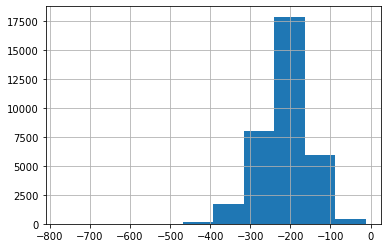

In [31]:
tool_name = 'RNAhybrid' #RNAhybrid
for how in ['ricseq']: #['ricseq', 'mario', 'test', 'splash']
    tool = pd.read_csv(os.path.join(external_dataset_dir, f'{tool_name}_{how}500.csv'), sep = ',').fillna(0)
    tool['value'] = tool['value'].astype(float)
    print(how)
    tool.value.hist()
    plt.show()
    print('\n')

# Map models signal in [0, 1] and save the mapping

##### Train the model (we train with paris)

In [10]:
threshold_remove_outliers = 2


dfs = []

for dataset in datasets:
    how = dataset if dataset != 'paris' else 'test'
    
    res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             False, 
                             False, 
                             False, 
                             False,
                             False, 
                             args_datasets[how]['MIN_N_READS_RICSEQ'], 
                             SPECIE_PARIS,
                             False,
                             False,
                             False
                            )
    
    df_training = res.copy()
    n_hardneg_easyneg_to_sample = df_training[df_training.policy == 'smartneg'].shape[0]
    easyneg_hardneg_training = df_training[df_training.policy.isin(['hardneg', 'easyneg'])]
    easyneg_hardneg_training = easyneg_hardneg_training.sample(n_hardneg_easyneg_to_sample)
    df_training = pd.concat([
        df_training[df_training.policy.isin(['smartneg', 'easypos'])],
        easyneg_hardneg_training
    ], axis = 0).reset_index(drop = True)
    dfs.append(df_training)

In [12]:
df_training = pd.concat(dfs, axis = 0).reset_index(drop = True)

In [13]:
logistic_regression_models = {}
for model_column in tqdm(energy_columns):
    
    
    df_s = df_training.copy()
    df_s = remove_outliers(df_s, model_column)
    df_s = balance_df(df_s)
    
    X_train, y_train = np.expand_dims(df_s[model_column], 1), np.array(df_s.ground_truth)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Calculate threshold_value
    threshold_value = -model.intercept_ / model.coef_
    threshold_value = np.round(threshold_value[0][0], 2)

    logistic_regression_models[model_column] = {'intercept': model.intercept_[0], 
                                               'coef': model.coef_[0][0],
                                               'threshold_value': threshold_value}

  0%|          | 0/8 [00:00<?, ?it/s]

### Test and plot 

  0%|          | 0/8 [00:00<?, ?it/s]

Accuracy: 0.5354
Threshold value: -8.07


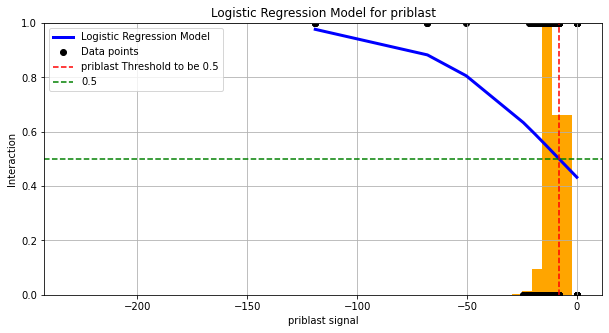

Accuracy: 0.5182
Threshold value: -9.77


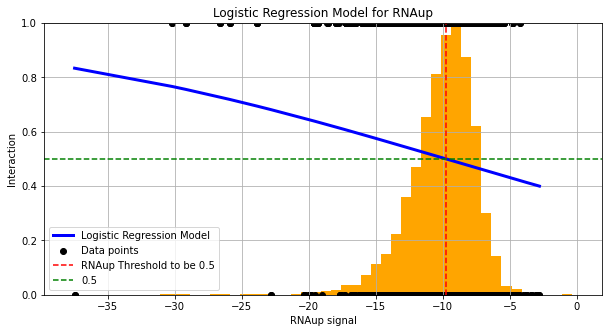

Accuracy: 0.5542
Threshold value: -33.3


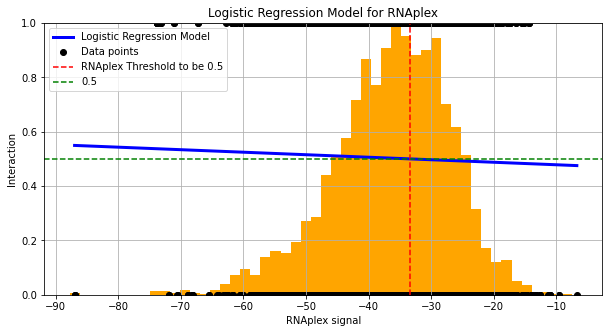

Accuracy: 0.613
Threshold value: -213.65


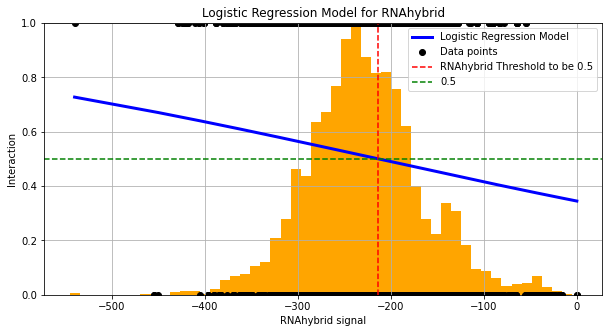

Accuracy: 0.5768
Threshold value: -318.28


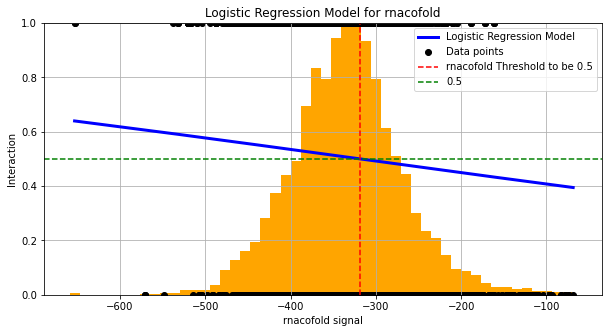

Accuracy: 0.5284
Threshold value: -41.73


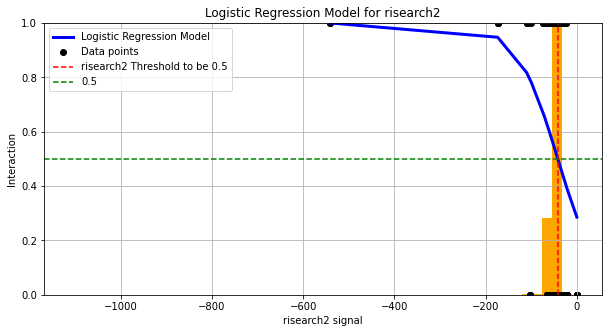

Accuracy: 0.522
Threshold value: -6.04


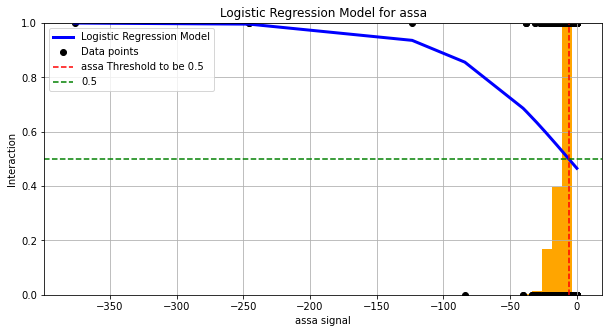

Accuracy: 0.5124
Threshold value: -1.23


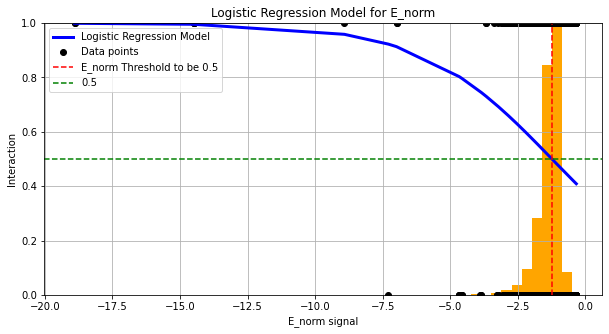

In [13]:
how = 'patches'

N_SAMPLES_TEST = 5000


plt.rcParams['figure.figsize'] = [10, 5]

for model_column in tqdm(energy_columns):
    if how == 'interactors':
        df_test = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True).copy()
    elif how == 'patches':
        df_test =res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True).copy()
      
    df_test = balance_df(df_test)
    
    sample_test = df_test.sample(N_SAMPLES_TEST)
    X_test, y_test = np.expand_dims(sample_test[model_column], 1), np.expand_dims(sample_test.ground_truth, 1)

    lrm_dict = logistic_regression_models[model_column]
    y_pred = log_func(lrm_dict['intercept'], lrm_dict['coef'], X_test)
    accuracy = accuracy_score(y_test, (y_pred>0.5).astype(int))
    
    print("Accuracy:", accuracy)

    threshold_value = lrm_dict['threshold_value']
    print("Threshold value:", threshold_value)


    #Plot model and predictions
    plot_histogram_01(df_test[model_column])
    plt.plot(np.sort(X_test, axis=0), 
             log_func(lrm_dict['intercept'], lrm_dict['coef'], np.sort(X_test, axis=0))[:, 0], 
             color='blue', linewidth=3, label='Logistic Regression Model')
    plt.scatter(X_test, y_test, color='black', label='Data points')    
    plt.axvline(x=threshold_value, color='r', linestyle='--', label=f'{model_column} Threshold to be 0.5')
    plt.axhline(y=0.5, color='g', linestyle='--', label='0.5')


    plt.ylim((0, 1))
    plt.xlabel(f'{model_column} signal')
    plt.ylabel('Interaction')
    plt.grid()
    plt.title(f'Logistic Regression Model for {model_column}')
    plt.legend()
    plt.show()

DATASET: paris


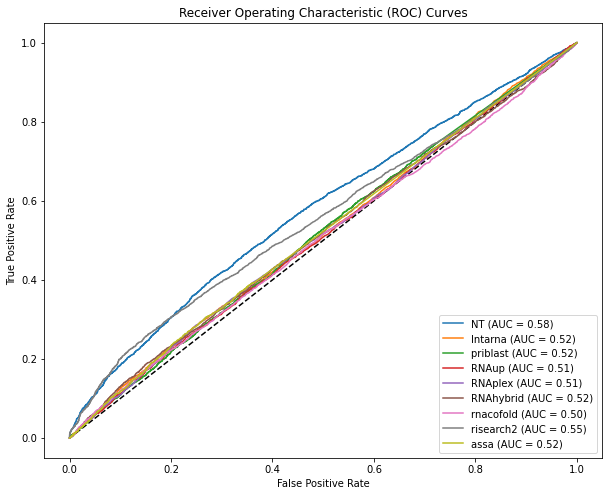

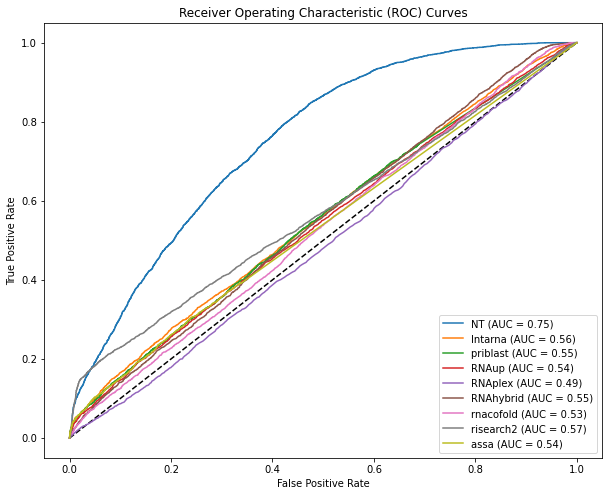




# excluded couples:  234
DATASET: ricseq


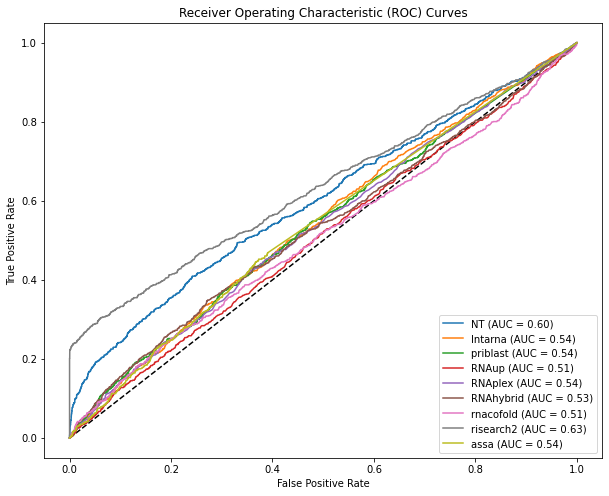

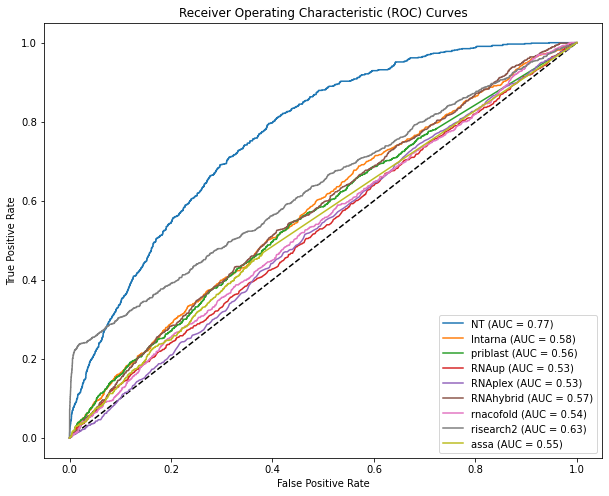




# excluded couples:  12
DATASET: splash


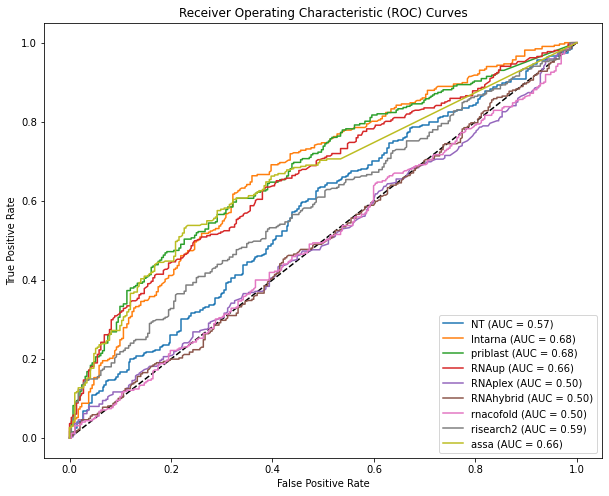

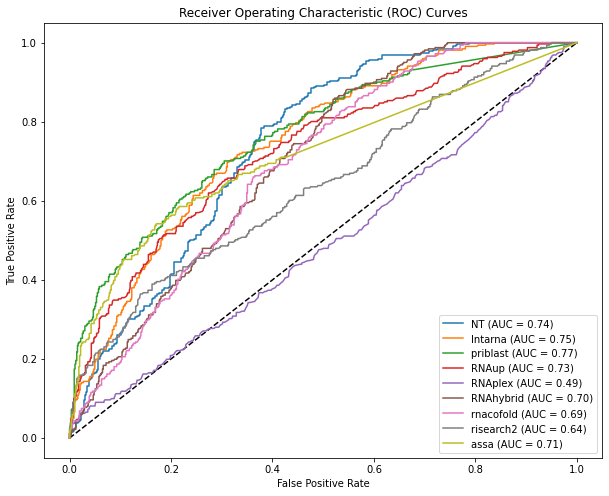




# excluded couples:  4
DATASET: mario


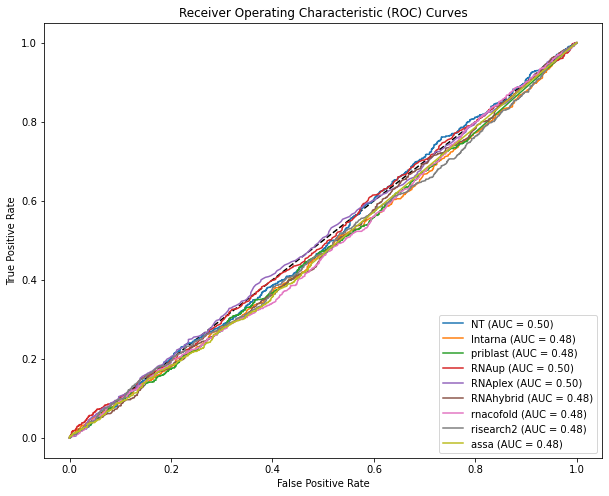

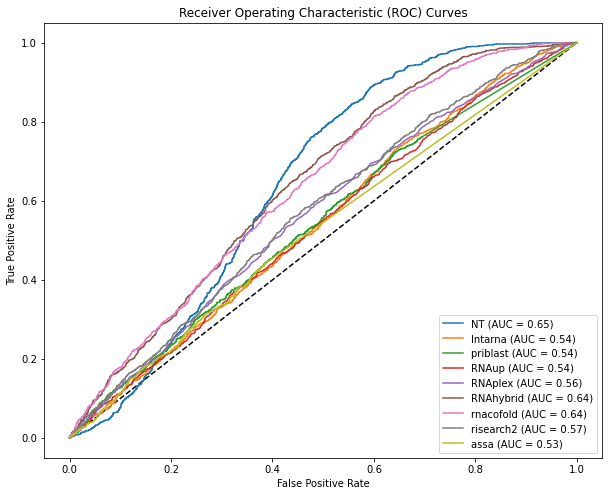

In [14]:
dfs = []

for dataset in datasets:
    how = dataset if dataset != 'paris' else 'test'
    res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                         args_datasets[how]['only_test'], 
                         args_datasets[how]['exclude_train_genes'], 
                         args_datasets[how]['exclude_paris_genes'], 
                         args_datasets[how]['exclude_paris_couples'],
                         args_datasets[how]['filter_hq_ricseq'], 
                         args_datasets[how]['MIN_N_READS_RICSEQ'], 
                         SPECIE_PARIS,
                         args_datasets[how]['PARIS_HQ'],
                         args_datasets[how]['PARIS_HQ_THRESHOLD'],
                         False,)
    for model_column in energy_columns:
        lrm_dict = logistic_regression_models[model_column]
        X_test = np.expand_dims(res[model_column], 1)
        y_pred = log_func(lrm_dict['intercept'], lrm_dict['coef'], X_test)
        res[model_column] = pd.Series(y_pred.flatten()) #modify column according to the model mapping
    
    easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
    easypos_smartneg = balance_df(easypos_smartneg)
    
    ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
    ephnen = balance_df(ephnen)
    
    
    m = obtain_all_model_auc(easypos_smartneg, tools).rename({'auc': f'auc_EPSN_{dataset}'}, axis = 1)
    m['model_name'] = m['model_name'] + '_logistic'
    dfs.append(m)
    
    m = obtain_all_model_auc(ephnen, tools).rename({'auc': f'auc_EPENHN_{dataset}'}, axis = 1)
    m['model_name'] = m['model_name'] + '_logistic'
    dfs.append(m)
    
    
    print(f'DATASET: {dataset}')
    plot_all_model_auc(easypos_smartneg, tools)
    plot_all_model_auc(ephnen, tools)
    print('\n\n')

In [15]:
df_auc2 = pd.concat(dfs, axis = 1)
df_auc2 = df_auc2.loc[:,~df_auc2.columns.duplicated()].copy()

In [16]:
errors = df_auc.drop('model_name', axis =1 ) - df_auc2.drop('model_name', axis =1 )

In [17]:
errors['model_name'] = df_auc['model_name']

In [18]:
errors

auc_EPSN_paris  auc_EPENHN_paris  auc_EPSN_ricseq  auc_EPENHN_ricseq  \
0             0.0               0.0              0.0               0.00   
1             0.0               0.0              0.0               0.00   
2             0.0               0.0              0.0               0.01   
3             0.0               0.0              0.0               0.00   
4             0.0               0.0              0.0               0.00   
5             0.0               0.0              0.0               0.00   
6             0.0               0.0              0.0               0.00   
7             0.0               0.0              0.0               0.00   
8             0.0               0.0              0.0               0.00   

   auc_EPSN_splash  auc_EPENHN_splash  auc_EPSN_mario  auc_EPENHN_mario  \
0             0.00               0.01             0.0               0.0   
1             0.00               0.00             0.0               0.0   
2             0.00               0.00             0.0               0.0   
3             0.00               0.00             0.0               0.0   
4             0.00               0.00             0.0               0.0   
5             0.00               0.00             0.0               0.0   
6             0.00               0.00             0.0               0.0   
7             0.00               0.00             0.0               0.0   
8             0.01               0.00             0.0               0.0   

  model_name  
0         NT  
1    INTARNA  
2   priblast  
3      RNAup  
4    RNAplex  
5  RNAhybrid  
6  rnacofold  
7  risearch2  
8       assa

In [26]:
# Open the file in binary write mode and serialize the dictionary
with open(LR_MAPPING_PATH, 'wb') as file:
    pickle.dump(logistic_regression_models, file)

# Model comparison

In [32]:
with open(LR_MAPPING_PATH, 'rb') as file:
    logistic_regression_models = pickle.load(file)

### Plots based on threshold

#### Come mai bilancio ad ogni step i pred_pos e i pred_neg? 

Supponiamo di avere livello di confidenza 0.9

qui abbiamo 10 sample di pred_pos, e 1000 sample di pred_neg. nei pred_pos li azzecchiamo tutti (erano tutti positivi) e nei pred neg facciamo 85% di accuracy sui negativi. Questo vuol dire che abbiamo:

- TP = 10
- TN = 850
- FN = 150
- FP = 0

Se calcoliamo la recall:

10/160 = 0.06

fa cagare. 

Se invece bilancio, avremmo:

- TP = 1000
- TN = 850
- FN = 150
- FP = 0

Se calcoliamo la recall:

1000/1150 = 0.87


In [33]:
#plot parameters
MIN_PERC = 0.5 #1 è 1%
list_of_models_to_test = ['nt'] + energy_columns
n_values = 12
n_run_undersampling = 10
list_of_metrics = ['f1'] #['f1'], ['f1', 'precision_recall_curve', 'precision', 'recall', 'npv']
figsize = (17,9)
size_multiplier = 10

balance_at_each_step = True

# RIPRENDI DA QUI 

Sto cercando di plottare piu modelli NT nello stesso plot

In [35]:
%load_ext autoreload
%autoreload 2
from util.evaluation import plot_results_of_all_models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
checkpoint_dir = [os.path.join(ROOT_DIR, 'checkpoints', _) for _ in nt_models]

list_of_models_to_test = list_of_models_to_test + [f'nt{_}' for _ in range(1, len(nt_models))]

In [46]:
plot_results_of_all_models(external_dataset_dir, checkpoint_dir, tools, logistic_regression_models, datasets, args_datasets, energy_columns, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, list_of_metrics, figsize, size_multiplier, based_on_threshold = True, balance_at_each_step=balance_at_each_step)

##############   ##############   ##############   ##############   ##############
---------- DATASET: paris ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  f1  -  -  - 


MemoryError: Unable to allocate 1.56 TiB for an array with shape (463300, 463300) and data type float64

<Figure size 1224x648 with 0 Axes>

### Plots based on top-bottom

In [10]:
#plot parameters
MIN_PERC = 1
list_of_metrics = ['precision', 'npv']
balance_at_each_step=False

##############   ##############   ##############   ##############   ##############
---------- DATASET: paris ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  precision  -  -  - 


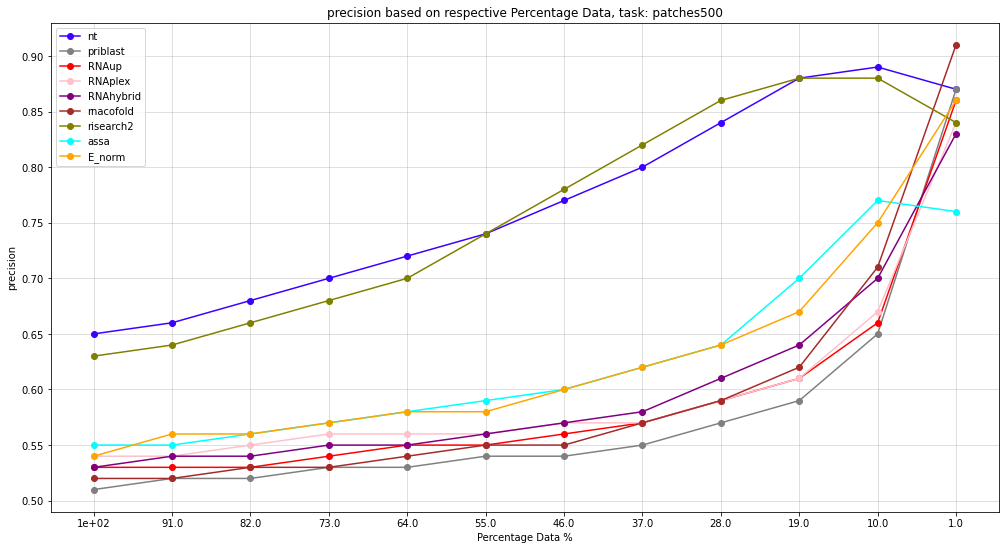

---------- DATASET: paris ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  npv  -  -  - 


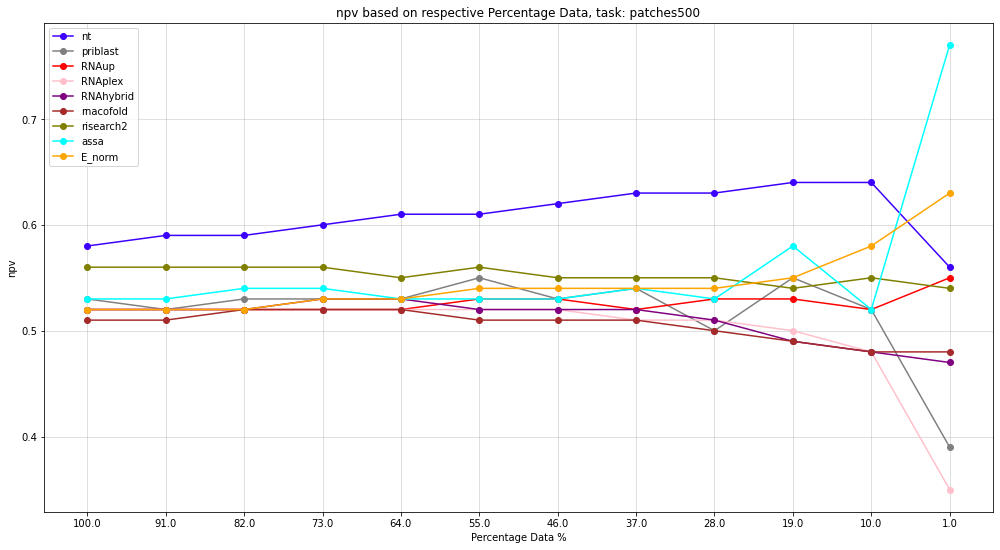




---------- DATASET: paris ----------
           -- -- -- patches -- -- -- 
           -  -  -  precision  -  -  - 


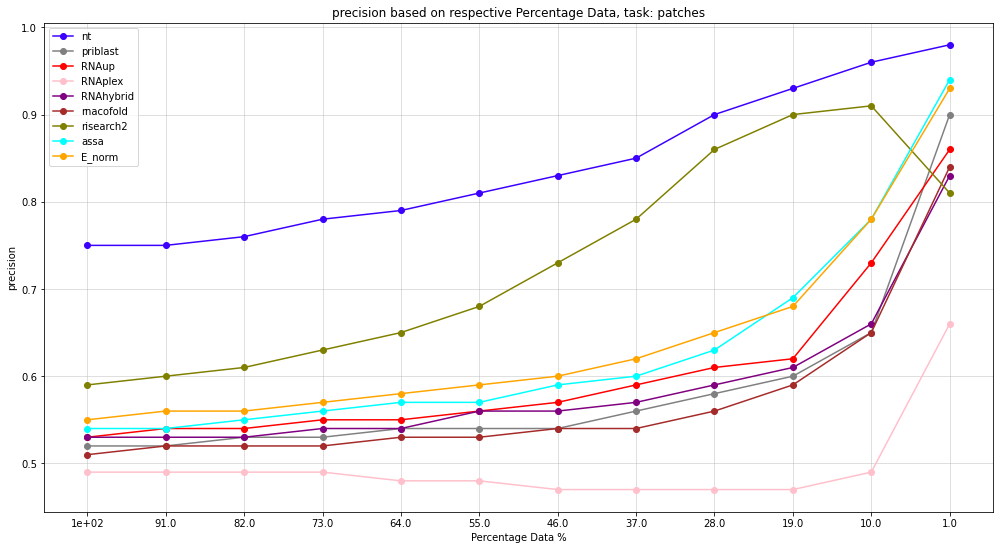

---------- DATASET: paris ----------
           -- -- -- patches -- -- -- 
           -  -  -  npv  -  -  - 


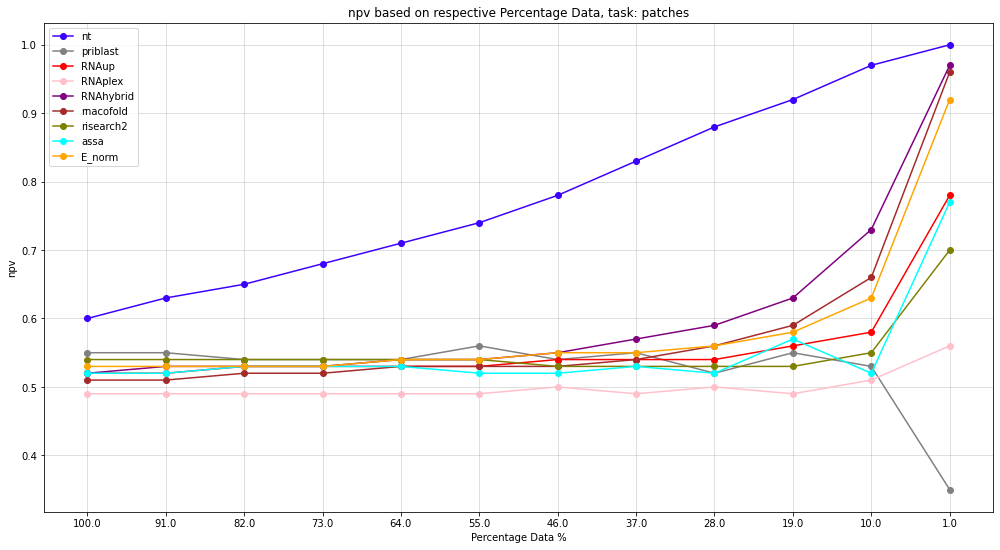




---------- DATASET: paris ----------
           -- -- -- interactors -- -- -- 
           -  -  -  precision  -  -  - 


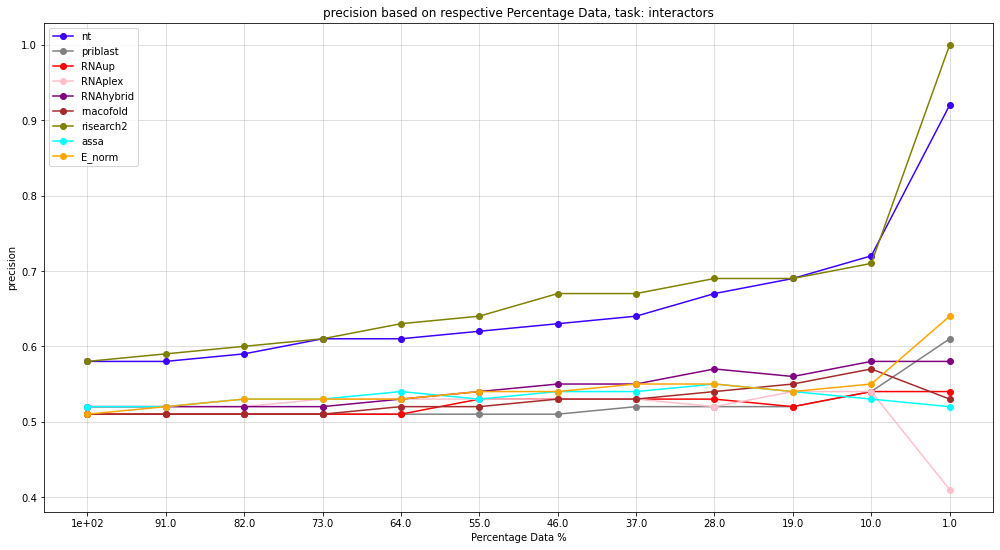

---------- DATASET: paris ----------
           -- -- -- interactors -- -- -- 
           -  -  -  npv  -  -  - 


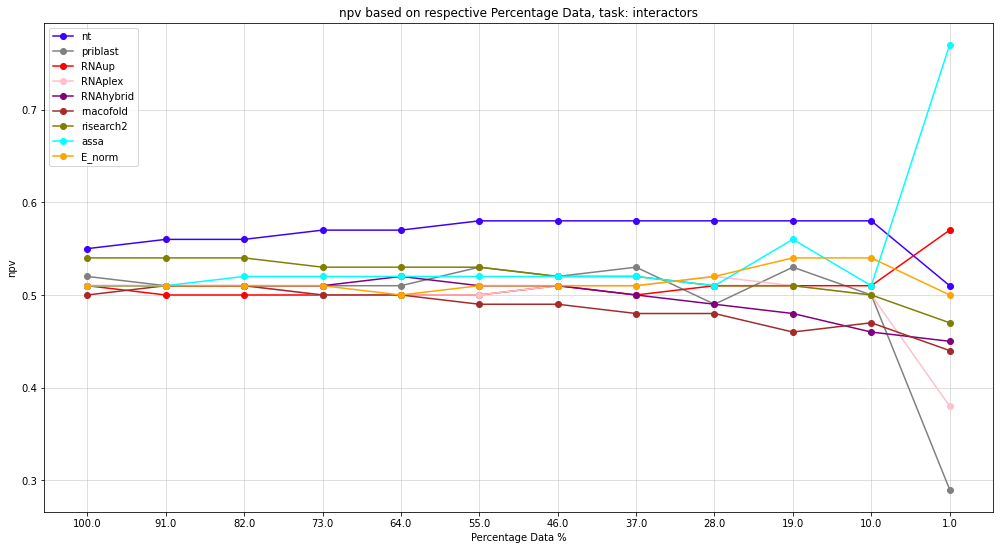




##############   ##############   ##############   ##############   ##############
# excluded couples:  234
# excluded couples:  234
---------- DATASET: ricseq ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  precision  -  -  - 


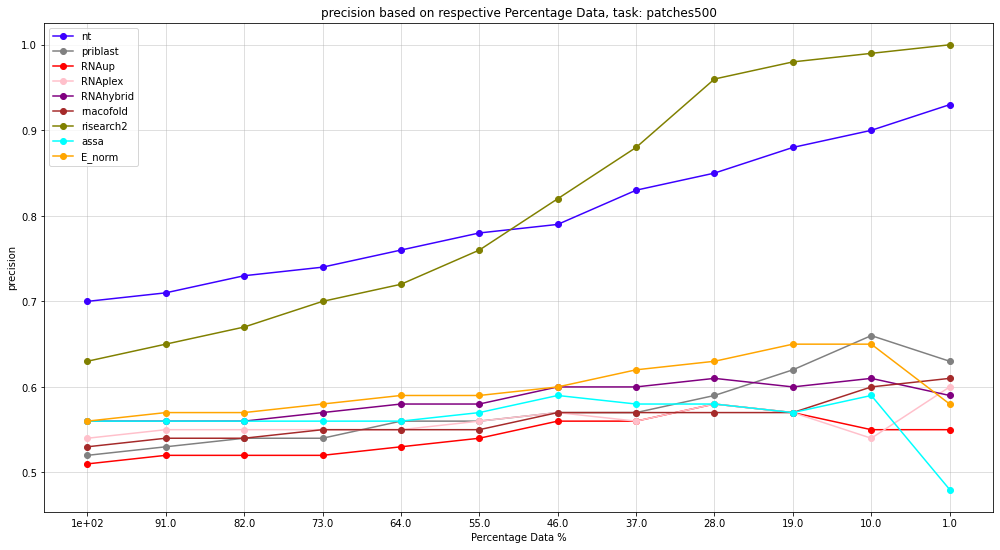

---------- DATASET: ricseq ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  npv  -  -  - 


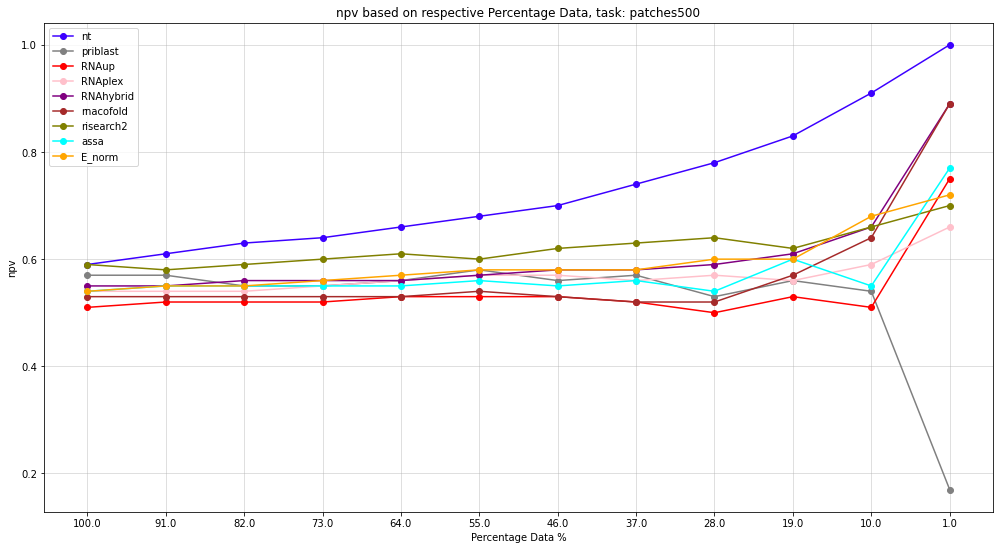




# excluded couples:  234
---------- DATASET: ricseq ----------
           -- -- -- patches -- -- -- 
           -  -  -  precision  -  -  - 


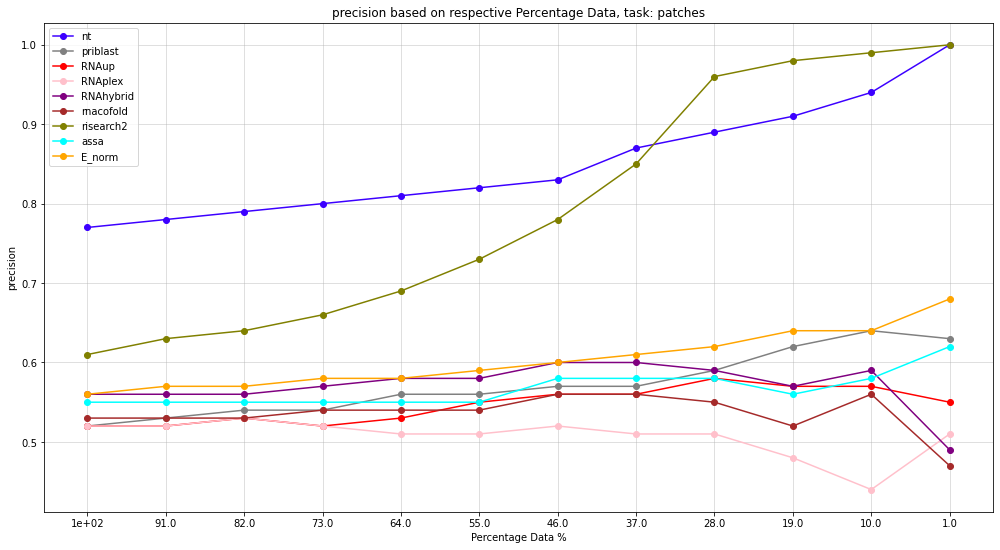

---------- DATASET: ricseq ----------
           -- -- -- patches -- -- -- 
           -  -  -  npv  -  -  - 


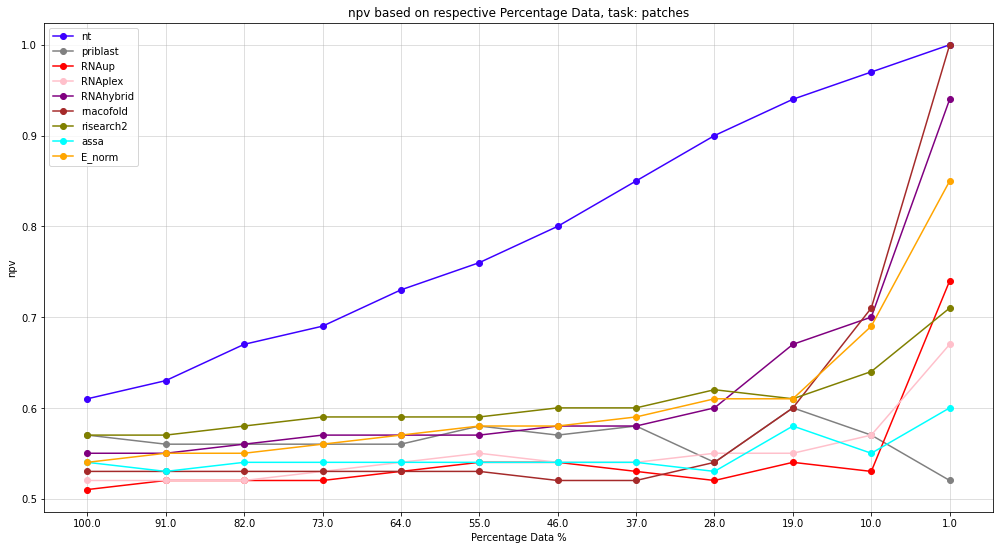




# excluded couples:  234
---------- DATASET: ricseq ----------
           -- -- -- interactors -- -- -- 
           -  -  -  precision  -  -  - 


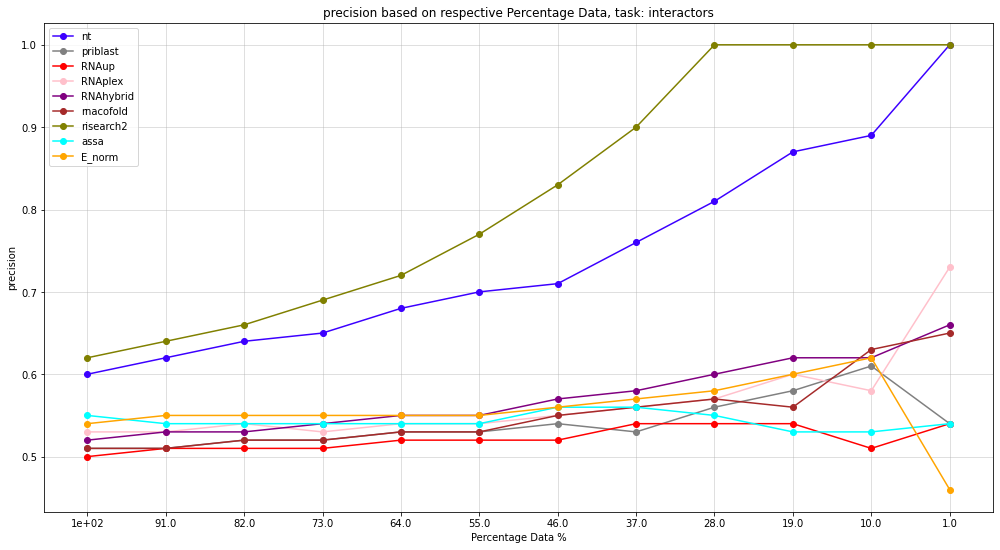

---------- DATASET: ricseq ----------
           -- -- -- interactors -- -- -- 
           -  -  -  npv  -  -  - 


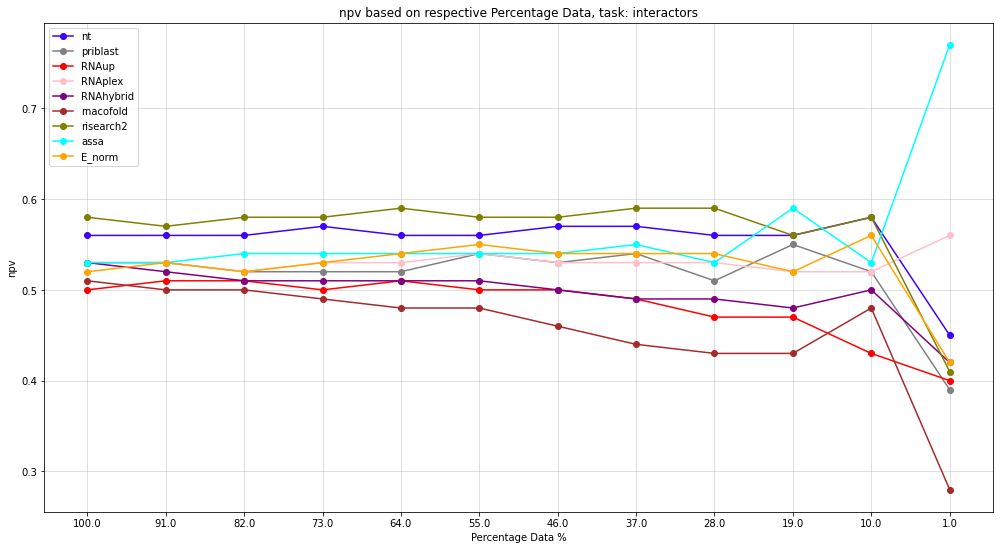




##############   ##############   ##############   ##############   ##############
# excluded couples:  12
# excluded couples:  12
---------- DATASET: splash ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  precision  -  -  - 


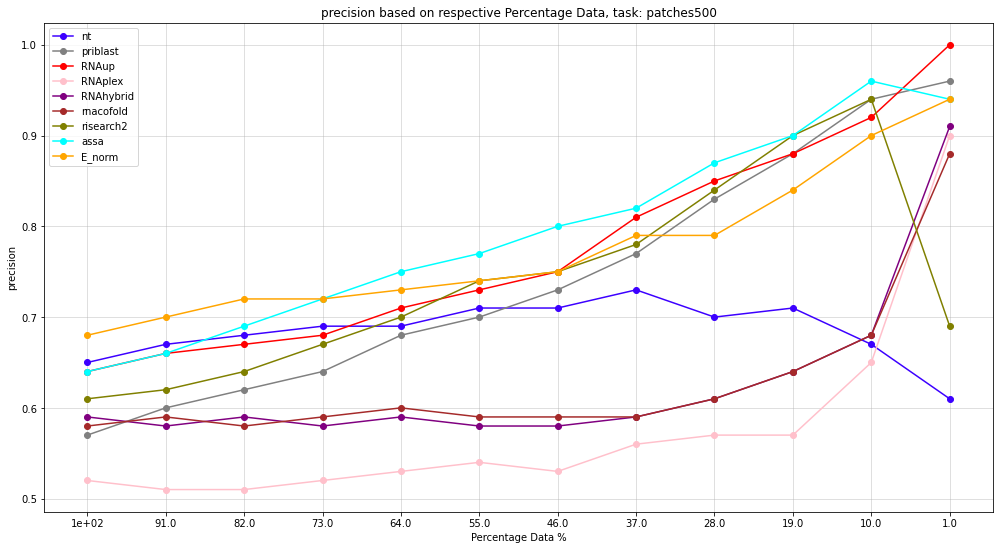

---------- DATASET: splash ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  npv  -  -  - 


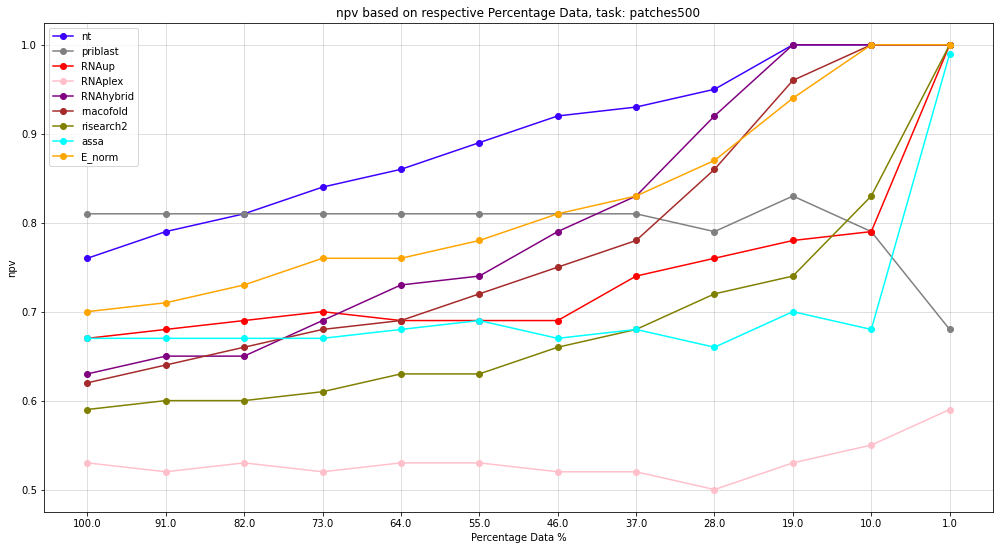




# excluded couples:  12
---------- DATASET: splash ----------
           -- -- -- patches -- -- -- 
           -  -  -  precision  -  -  - 


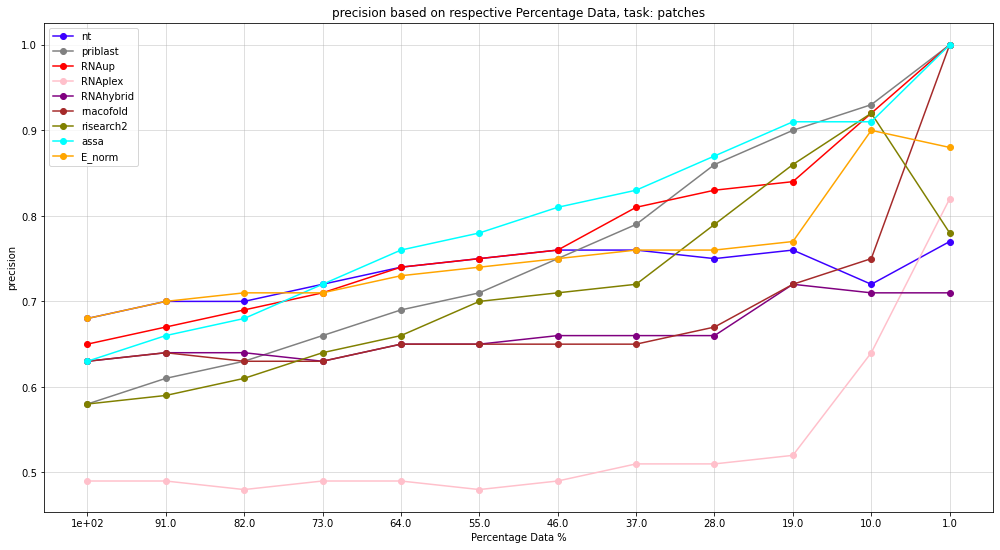

---------- DATASET: splash ----------
           -- -- -- patches -- -- -- 
           -  -  -  npv  -  -  - 


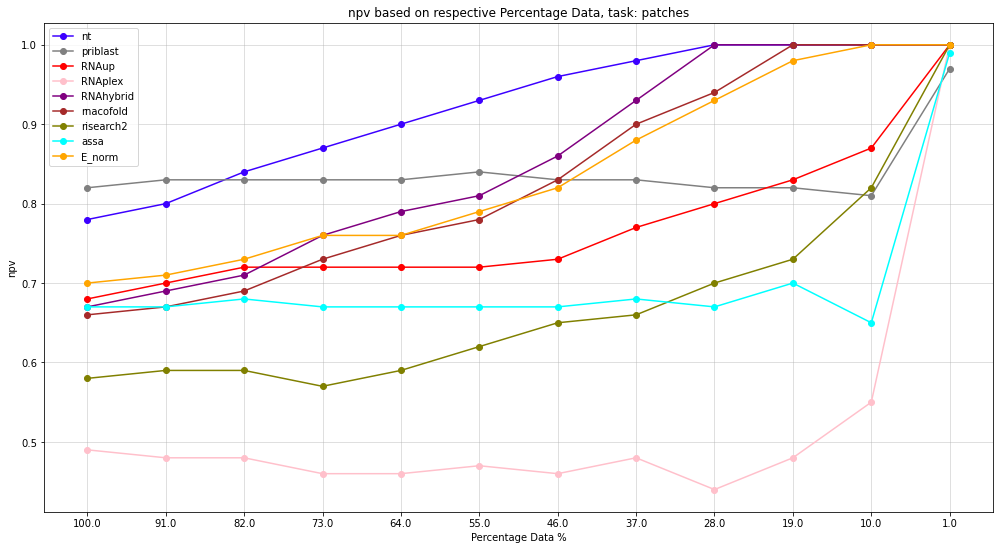




# excluded couples:  12
---------- DATASET: splash ----------
           -- -- -- interactors -- -- -- 
           -  -  -  precision  -  -  - 


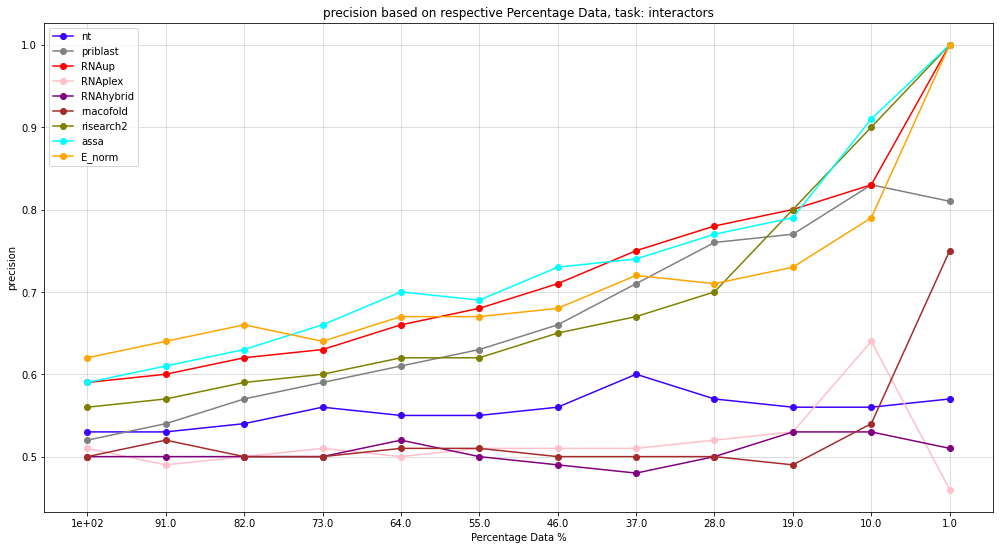

---------- DATASET: splash ----------
           -- -- -- interactors -- -- -- 
           -  -  -  npv  -  -  - 


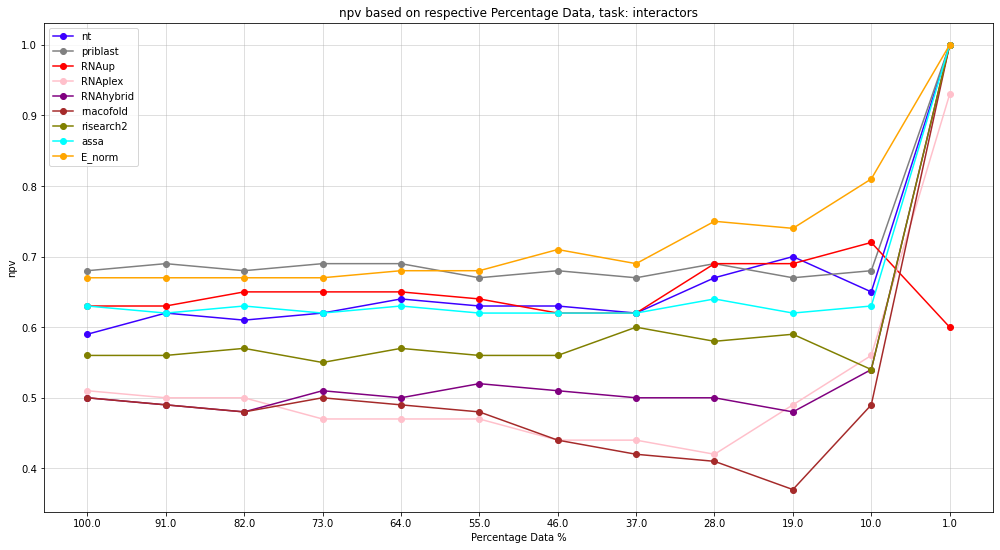




##############   ##############   ##############   ##############   ##############
# excluded couples:  4
# excluded couples:  4
---------- DATASET: mario ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  precision  -  -  - 


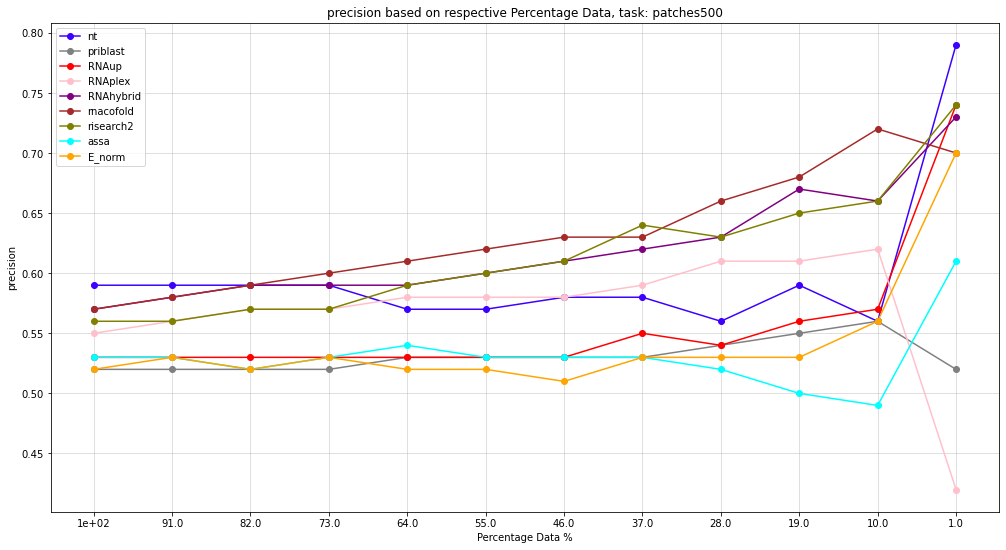

---------- DATASET: mario ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  npv  -  -  - 


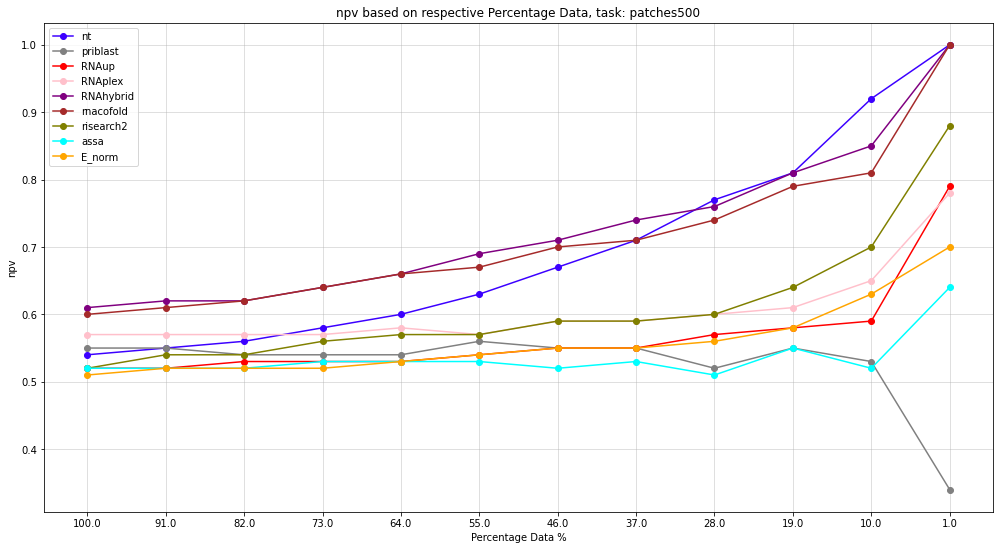




# excluded couples:  4
---------- DATASET: mario ----------
           -- -- -- patches -- -- -- 
           -  -  -  precision  -  -  - 


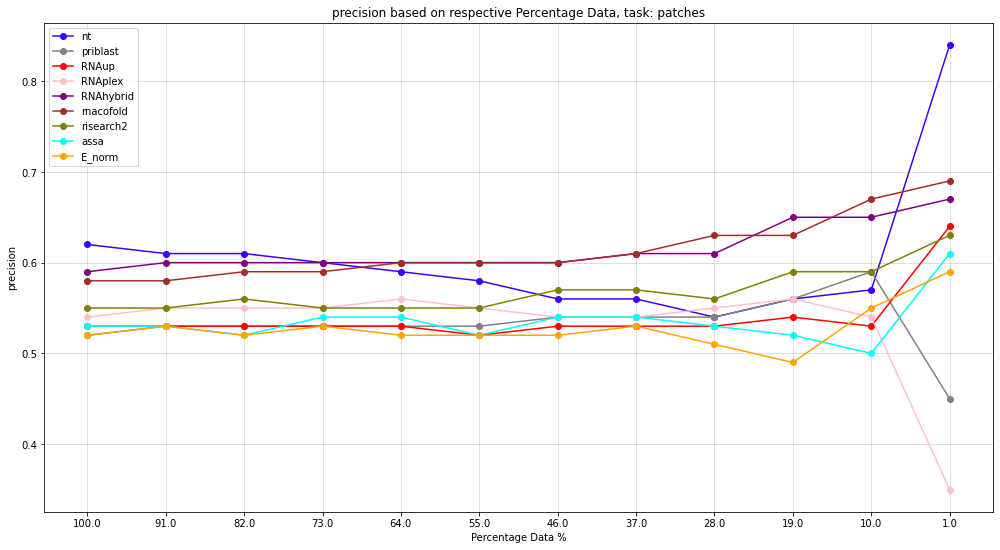

---------- DATASET: mario ----------
           -- -- -- patches -- -- -- 
           -  -  -  npv  -  -  - 


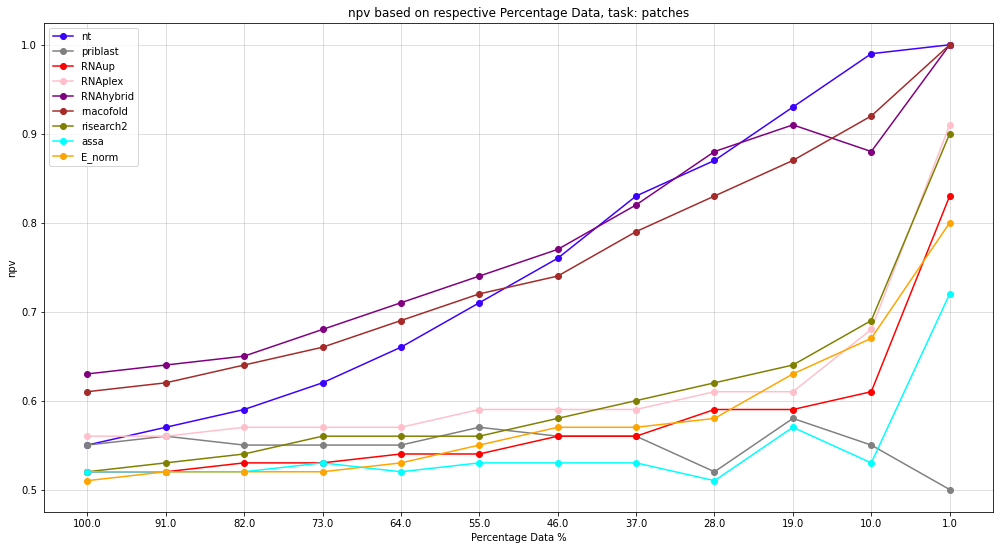




# excluded couples:  4
---------- DATASET: mario ----------
           -- -- -- interactors -- -- -- 
           -  -  -  precision  -  -  - 


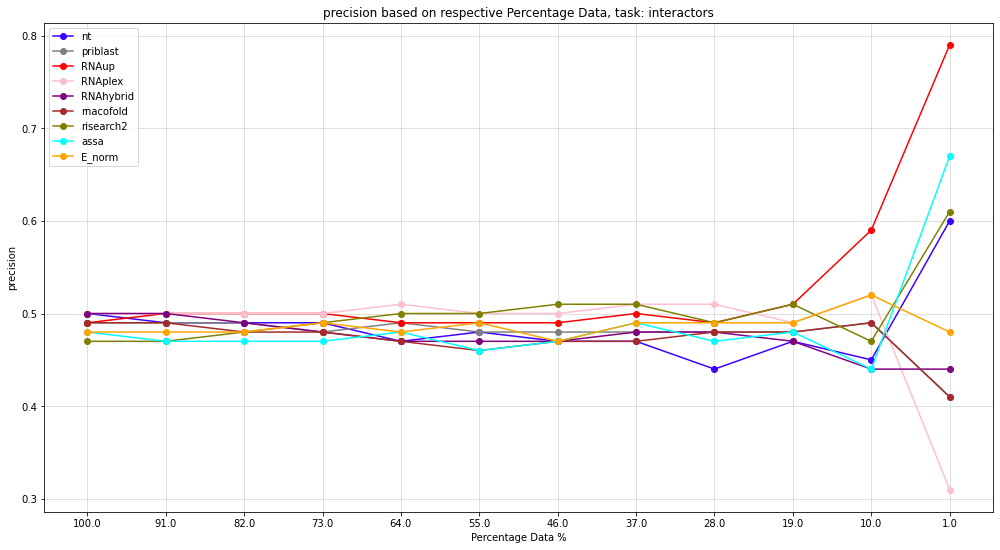

---------- DATASET: mario ----------
           -- -- -- interactors -- -- -- 
           -  -  -  npv  -  -  - 


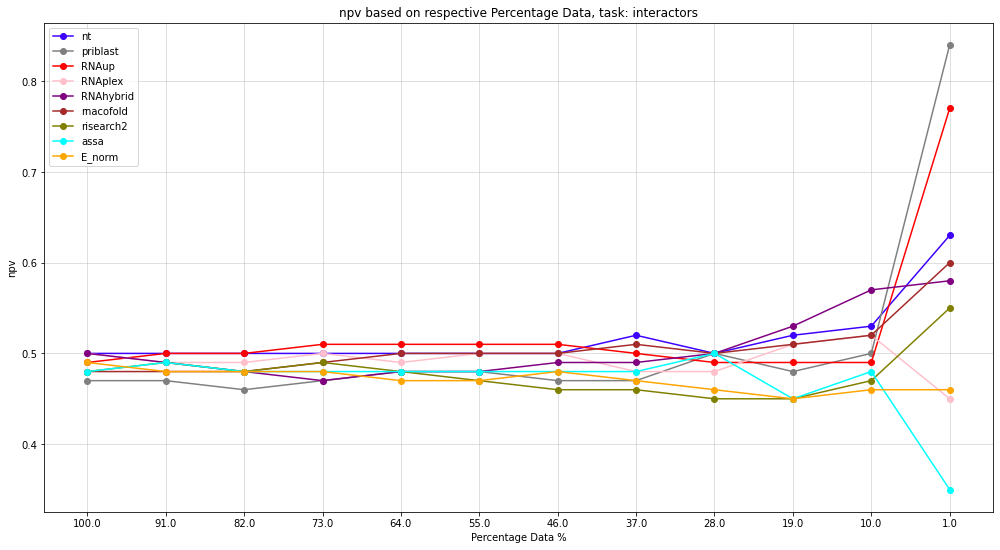

In [11]:
plot_results_of_all_models(external_dataset_dir, checkpoint_dir, tools, logistic_regression_models, datasets, args_datasets, energy_columns, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, list_of_metrics, figsize, size_multiplier, based_on_threshold = False, balance_at_each_step=balance_at_each_step)

# Repeats enrichment

In Paris, le SR sono > delle non SR solo se paris_hq = False, quindi solo se non consideriamo nei positivi.

In [12]:
#analysis args
feature_to_search = 'Simple_repeat'


full_overlap = False
if full_overlap:
    suffix = 'full_'
else:
    suffix = ''
    
both_sr_condition = True

In [13]:
#kde plot args
figsize_kde = (7, 4)

#treshold plot args
figsize_treshold = (17,9)
MIN_PERC = 1
list_of_models_to_test = ['nt'] + energy_columns
n_values = 12
size_multiplier = 10
n_run_undersampling = 15
list_of_metrics = ['recall', 'precision_recall_curve']
plot_function = plot_results_based_on_treshold_for_all_models
balance_at_each_step = True
tasks_treshold = ['simple_repeat_EPSN', 'no_simple_repeat_EPSN']

##############   ##############   ##############   ##############   ##############
---------- DATASET: paris ----------
Simple_repeat are the 2.2639136358872234  % of the total couples
No Simple_repeat are the 74.40519861649723  % of the total couples


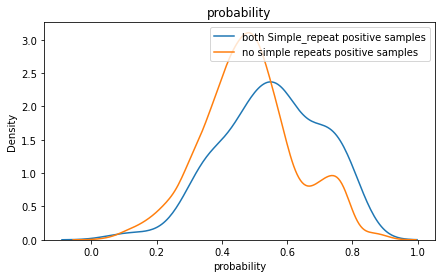

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2711582088
P-value: 1.348e-07

Test di Mann-Whitney U:
Statistiche U: 249640.0
P-value: 5.995e-07




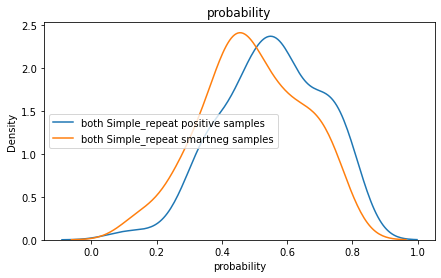

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2031102328
P-value: 0.019391846

Test di Mann-Whitney U:
Statistiche U: 7112.0
P-value: 0.00485935




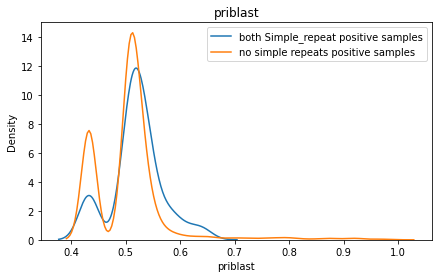

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2071317623
P-value: 0.0001350206

Test di Mann-Whitney U:
Statistiche U: 246316.5
P-value: 2.3098e-06




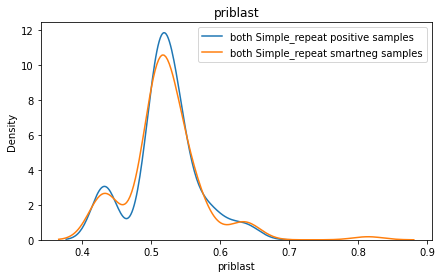

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.0860039522
P-value: 0.7764501979

Test di Mann-Whitney U:
Statistiche U: 6130.0
P-value: 0.4985857858




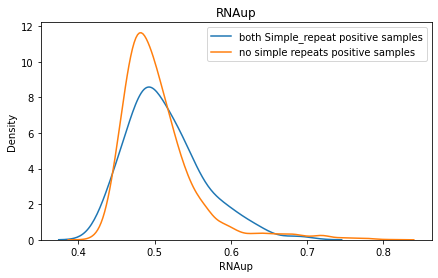

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1390816285
P-value: 0.0261074301

Test di Mann-Whitney U:
Statistiche U: 221052.5
P-value: 0.0190165964




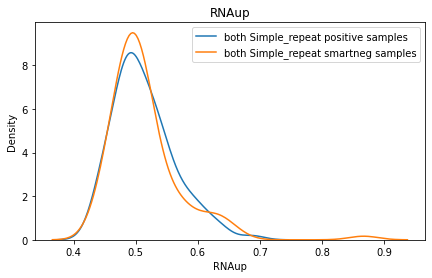

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1069679526
P-value: 0.521137409

Test di Mann-Whitney U:
Statistiche U: 5955.5
P-value: 0.7677219883




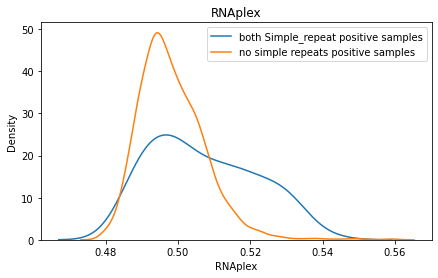

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3280697541
P-value: 1e-10

Test di Mann-Whitney U:
Statistiche U: 262838.0
P-value: 5e-10




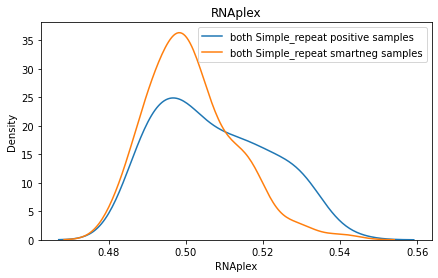

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2148810035
P-value: 0.0111955768

Test di Mann-Whitney U:
Statistiche U: 7079.5
P-value: 0.0060434335




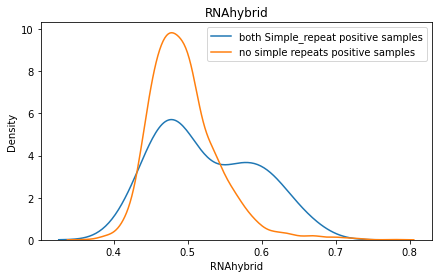

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2795913466
P-value: 4.68e-08

Test di Mann-Whitney U:
Statistiche U: 241427.5
P-value: 2.32452e-05




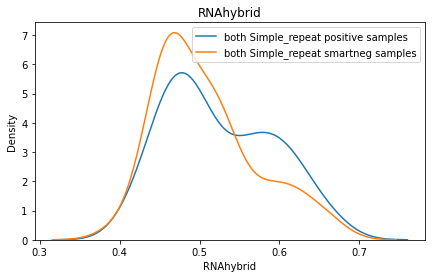

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1749291176
P-value: 0.063013561

Test di Mann-Whitney U:
Statistiche U: 6663.0
P-value: 0.0661338288




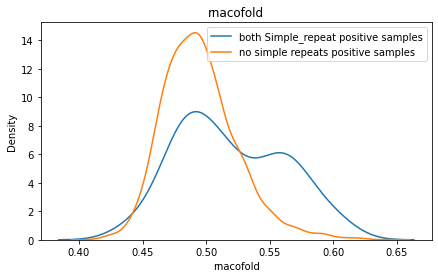

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2937368432
P-value: 7.4e-09

Test di Mann-Whitney U:
Statistiche U: 260665.0
P-value: 1.8e-09




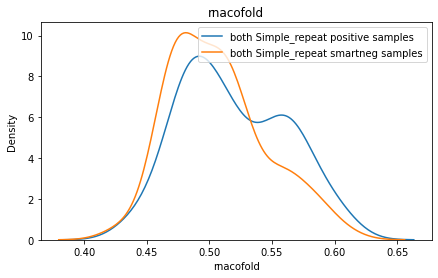

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1872153965
P-value: 0.0384423116

Test di Mann-Whitney U:
Statistiche U: 6889.5
P-value: 0.0197414883




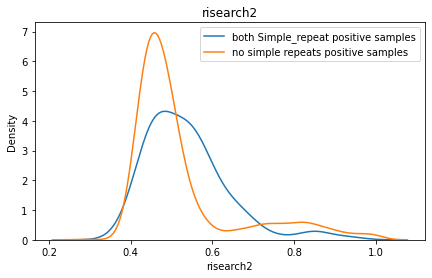

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2582670809
P-value: 6.333e-07

Test di Mann-Whitney U:
Statistiche U: 238009.0
P-value: 9.04922e-05




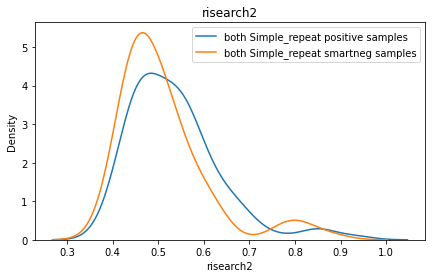

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2114442822
P-value: 0.0131839316

Test di Mann-Whitney U:
Statistiche U: 6991.0
P-value: 0.0106961984




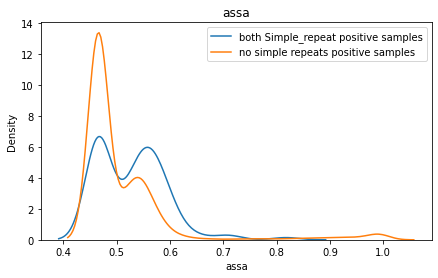

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2772103456
P-value: 6.34e-08

Test di Mann-Whitney U:
Statistiche U: 250159.5
P-value: 6.6e-09




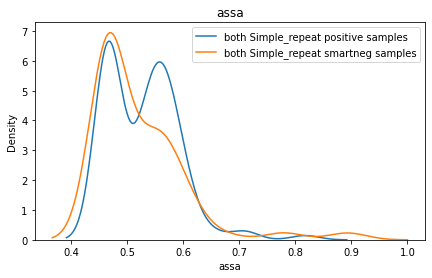

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1603230518
P-value: 0.1086273691

Test di Mann-Whitney U:
Statistiche U: 6555.5
P-value: 0.0911843877




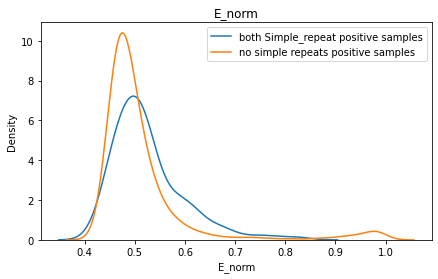

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2274469129
P-value: 1.85876e-05

Test di Mann-Whitney U:
Statistiche U: 239781.5
P-value: 4.52617e-05




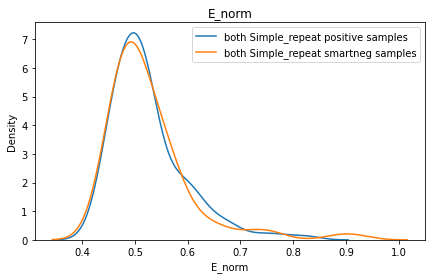

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.0763811324
P-value: 0.8782198286

Test di Mann-Whitney U:
Statistiche U: 5942.0
P-value: 0.7902946707





           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  recall  -  -  - 


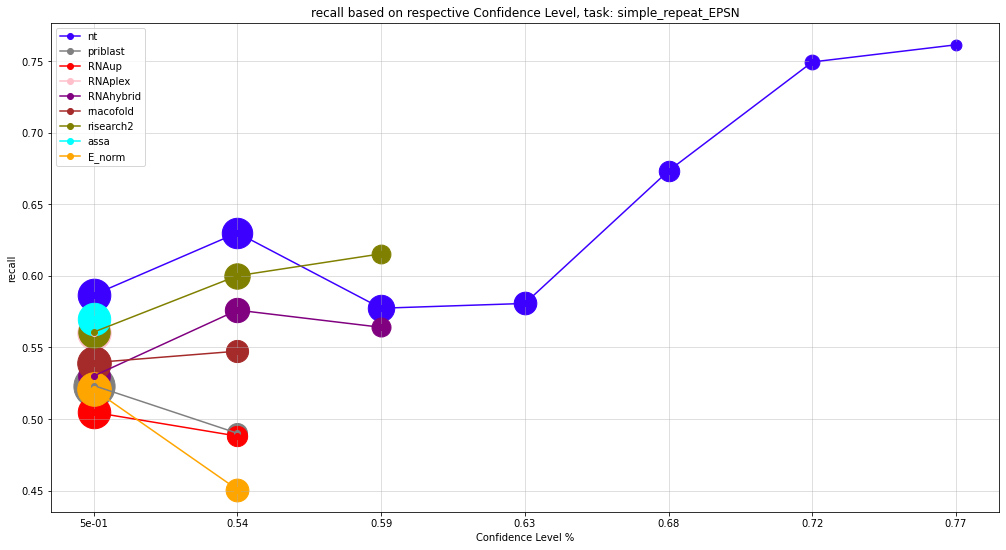

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  recall  -  -  - 


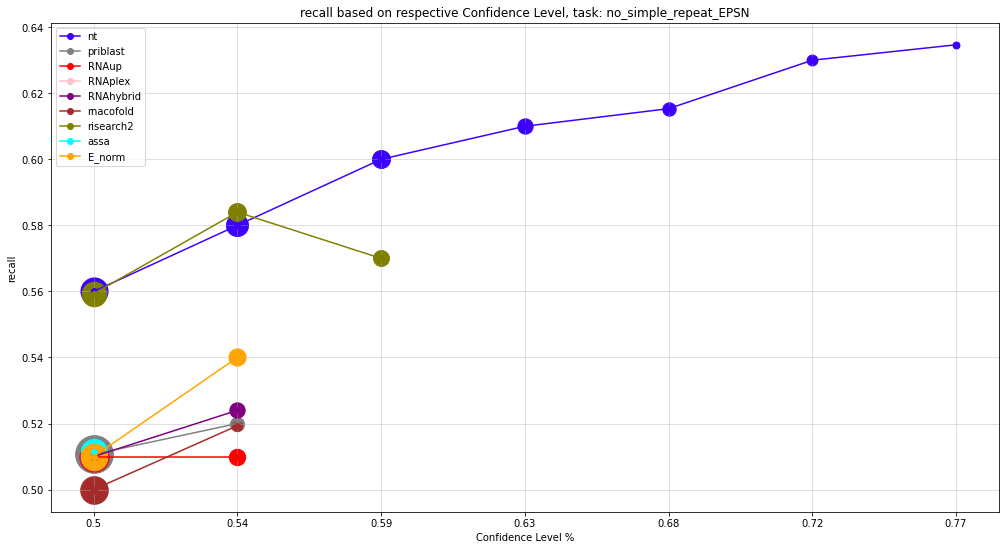

           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


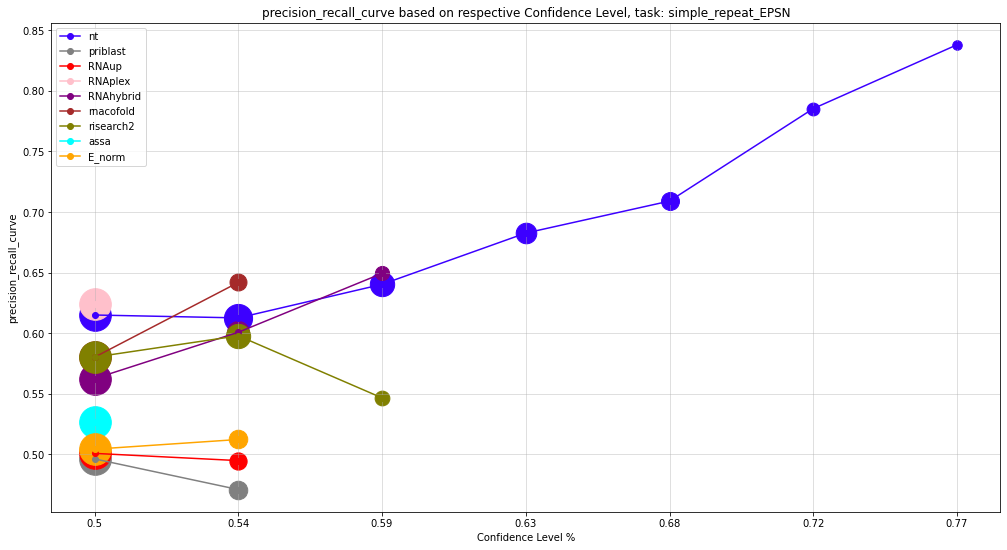

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


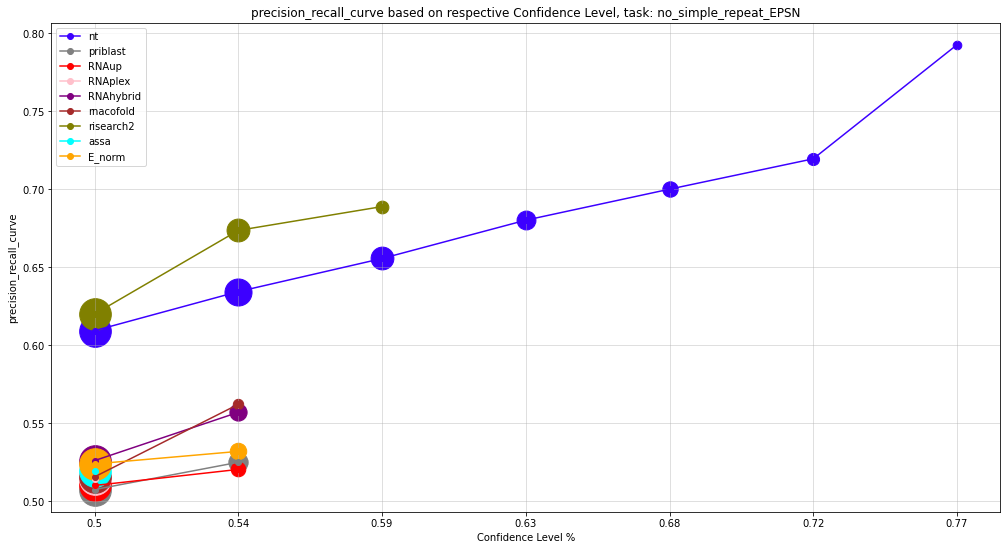




EASYPOS Percentage of SR in positive predictions based on model Confidence Levels


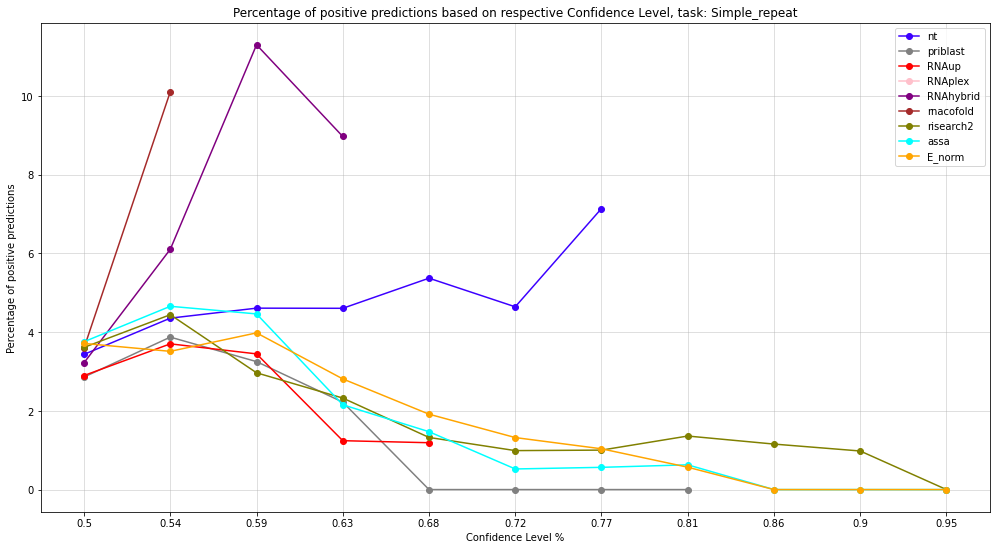

SMARTNEG Percentage of SR in positive predictions based on model Confidence Levels


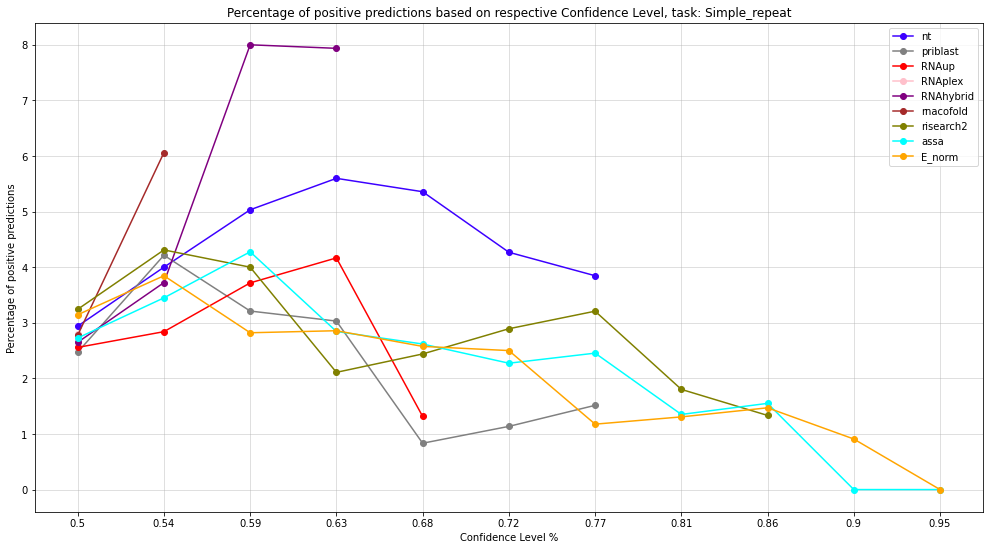




##############   ##############   ##############   ##############   ##############
---------- DATASET: ricseq ----------
# excluded couples:  234
Simple_repeat are the 1.601726684084971  % of the total couples
No Simple_repeat are the 77.35999091218902  % of the total couples


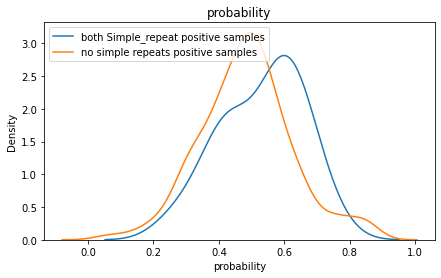

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2996387563
P-value: 0.0287542462

Test di Mann-Whitney U:
Statistiche U: 9532.0
P-value: 0.0607869319




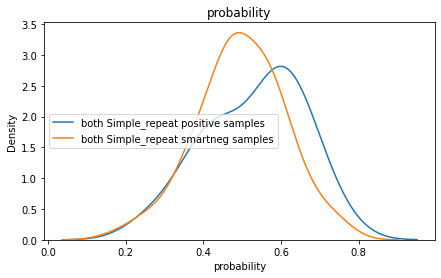

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2601326455
P-value: 0.1210427083

Test di Mann-Whitney U:
Statistiche U: 1605.0
P-value: 0.167256421




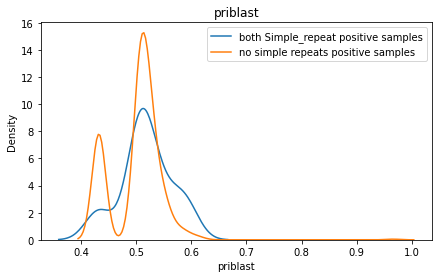

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1901045026
P-value: 0.3509307657

Test di Mann-Whitney U:
Statistiche U: 8940.0
P-value: 0.2074441109




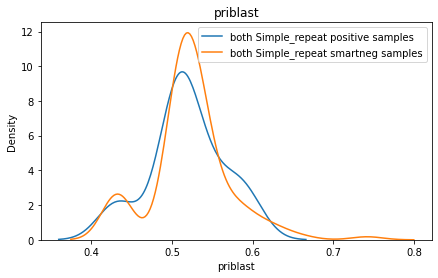

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2347089167
P-value: 0.2015544835

Test di Mann-Whitney U:
Statistiche U: 1215.5
P-value: 0.430924563




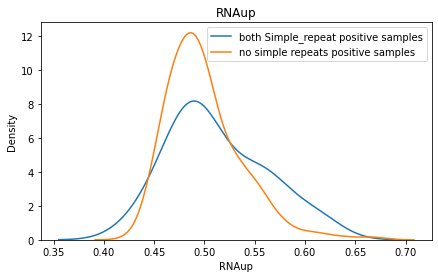

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1945555412
P-value: 0.3243688915

Test di Mann-Whitney U:
Statistiche U: 8976.0
P-value: 0.1972161306




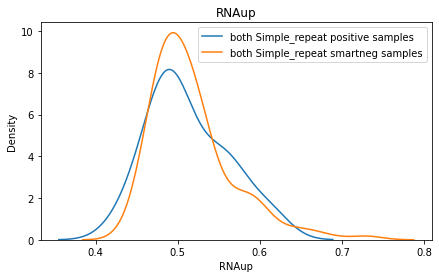

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1256448047
P-value: 0.8781960508

Test di Mann-Whitney U:
Statistiche U: 1312.5
P-value: 0.8060483781




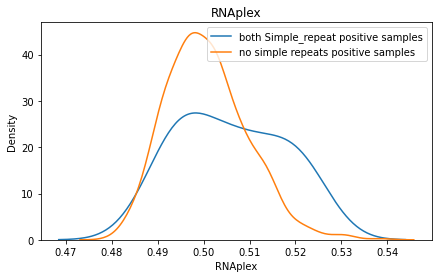

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2537737066
P-value: 0.0945014197

Test di Mann-Whitney U:
Statistiche U: 9757.0
P-value: 0.0346852958




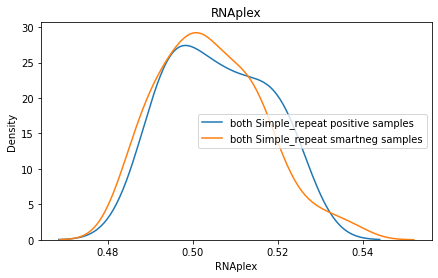

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1263817244
P-value: 0.8732873525

Test di Mann-Whitney U:
Statistiche U: 1483.5
P-value: 0.4819816185




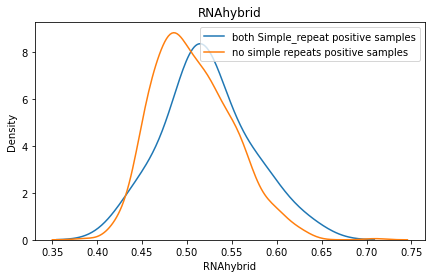

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3067991227
P-value: 0.0234593016

Test di Mann-Whitney U:
Statistiche U: 9235.0
P-value: 0.1182236736




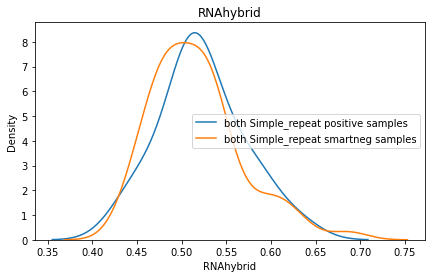

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2582903464
P-value: 0.1256918376

Test di Mann-Whitney U:
Statistiche U: 1502.0
P-value: 0.4200562808




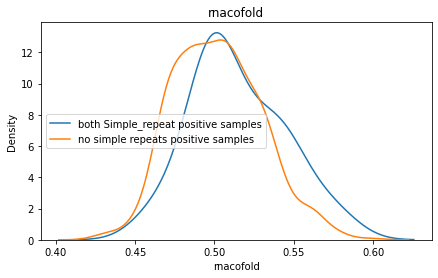

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.307702232
P-value: 0.0228295731

Test di Mann-Whitney U:
Statistiche U: 9656.5
P-value: 0.0448396855




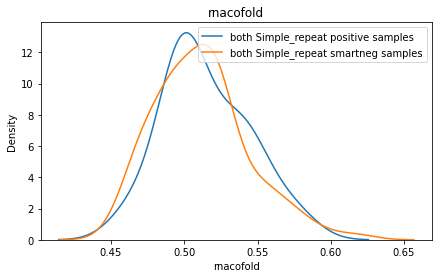

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2011790715
P-value: 0.3621646107

Test di Mann-Whitney U:
Statistiche U: 1461.0
P-value: 0.5635723912




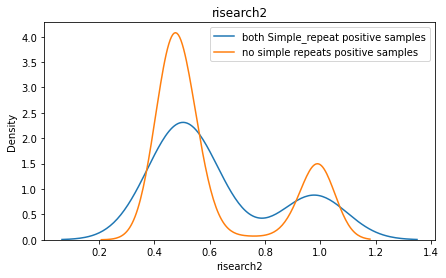

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2450651529
P-value: 0.1157696393

Test di Mann-Whitney U:
Statistiche U: 8819.5
P-value: 0.2607119815




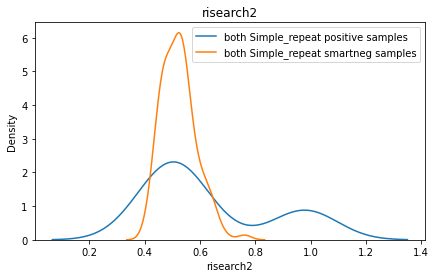

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2608695652
P-value: 0.1182144879

Test di Mann-Whitney U:
Statistiche U: 1559.5
P-value: 0.259665777




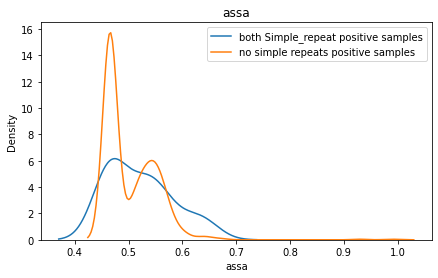

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1745581215
P-value: 0.454765018

Test di Mann-Whitney U:
Statistiche U: 8996.5
P-value: 0.1539053482




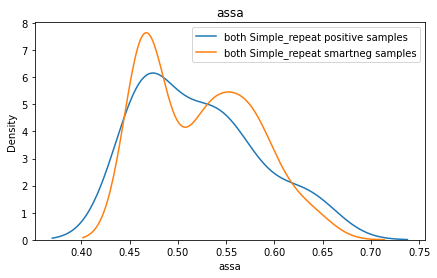

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1057479735
P-value: 0.9641344821

Test di Mann-Whitney U:
Statistiche U: 1289.5
P-value: 0.6993816204




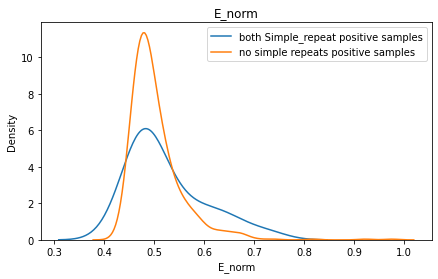

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.16842988
P-value: 0.4989947795

Test di Mann-Whitney U:
Statistiche U: 8593.0
P-value: 0.3755185026




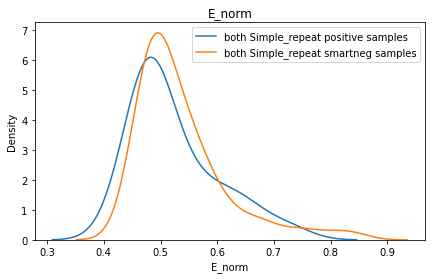

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2251289609
P-value: 0.2408760914

Test di Mann-Whitney U:
Statistiche U: 1150.0
P-value: 0.2492006315





           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  recall  -  -  - 


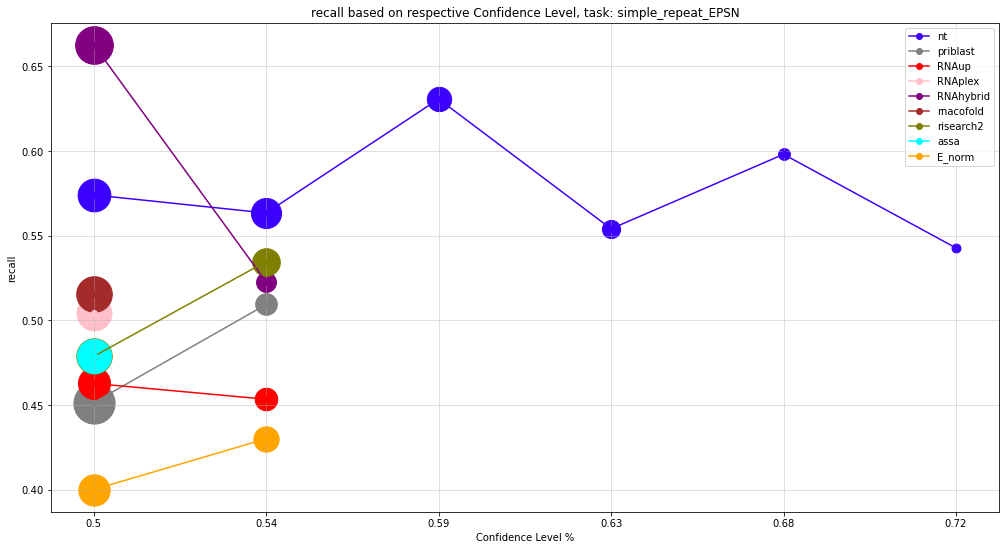

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  recall  -  -  - 


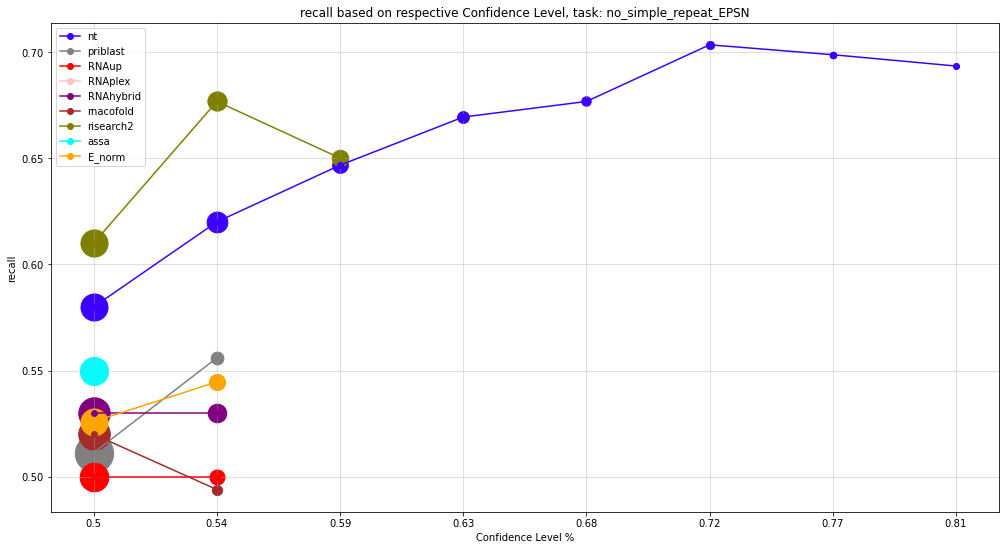

           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


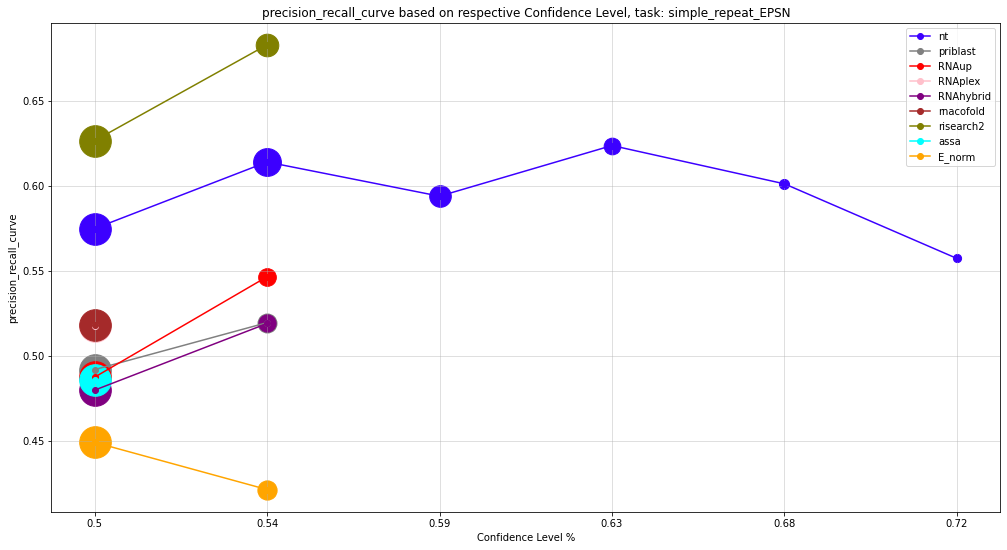

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


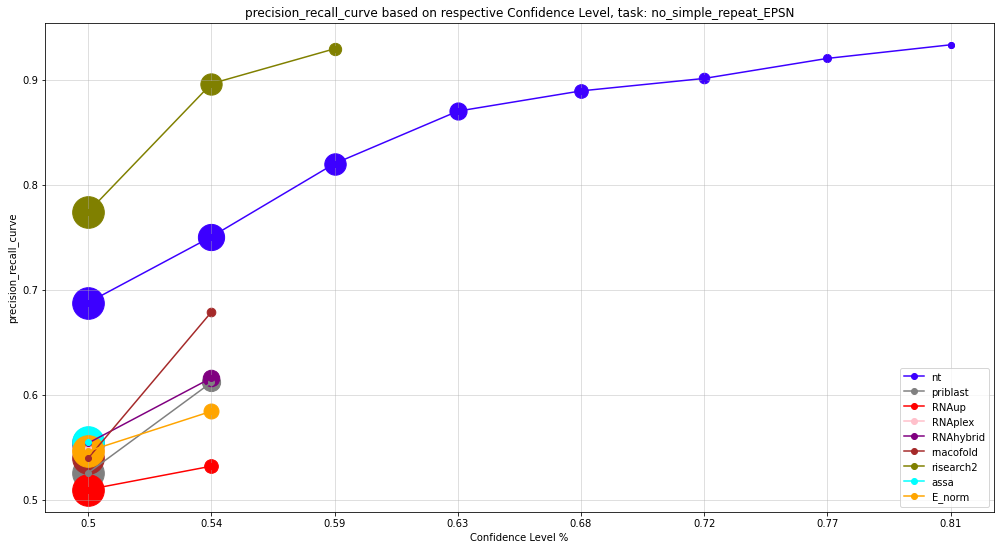




EASYPOS Percentage of SR in positive predictions based on model Confidence Levels


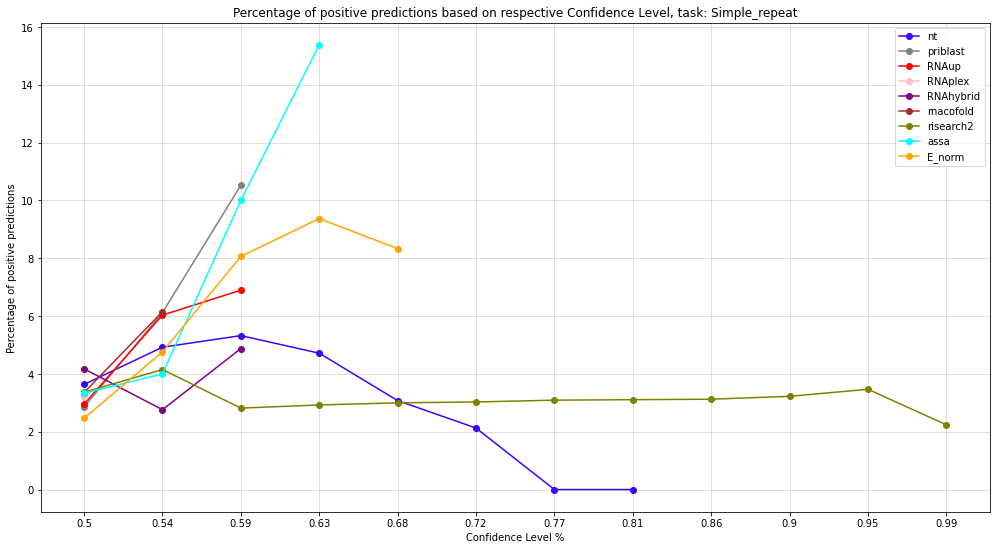

SMARTNEG Percentage of SR in positive predictions based on model Confidence Levels


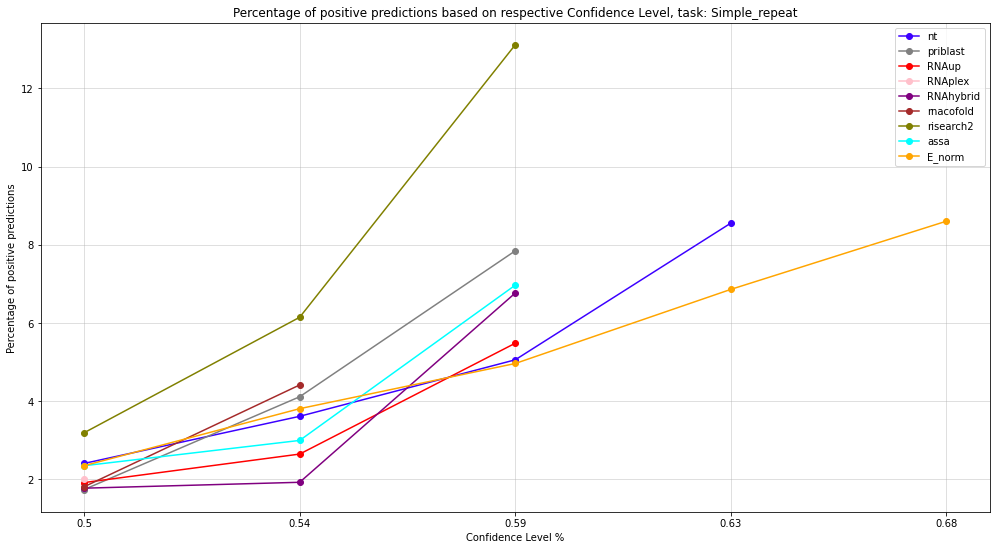




##############   ##############   ##############   ##############   ##############
---------- DATASET: splash ----------
# excluded couples:  12
Simple_repeat are the 7.01468189233279  % of the total couples
No Simple_repeat are the 62.96900489396411  % of the total couples


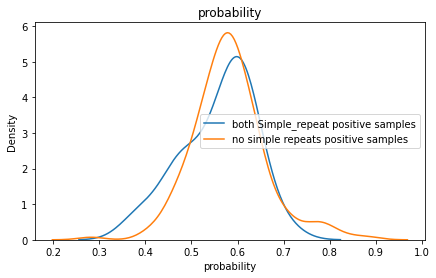

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1852117732
P-value: 0.3233176534

Test di Mann-Whitney U:
Statistiche U: 2513.0
P-value: 0.4023122958




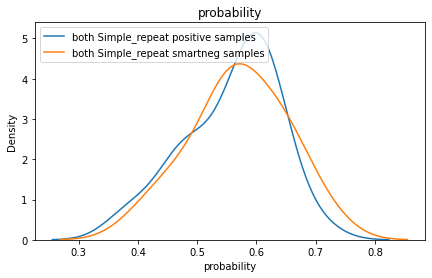

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1904761905
P-value: 0.7907613746

Test di Mann-Whitney U:
Statistiche U: 198.0
P-value: 0.7694861238




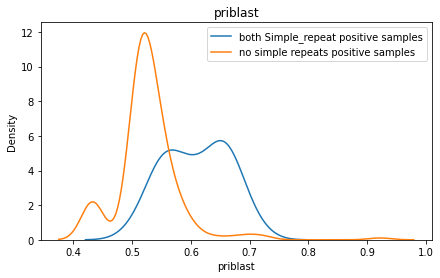

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.6762383345
P-value: 0.0

Test di Mann-Whitney U:
Statistiche U: 4922.0
P-value: 1e-10




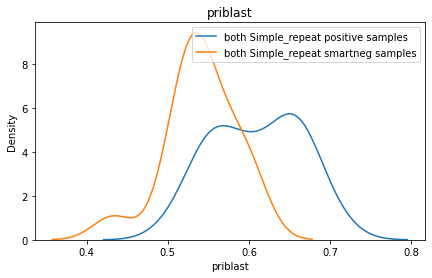

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.5238095238
P-value: 0.0050572831

Test di Mann-Whitney U:
Statistiche U: 348.0
P-value: 0.0004586276




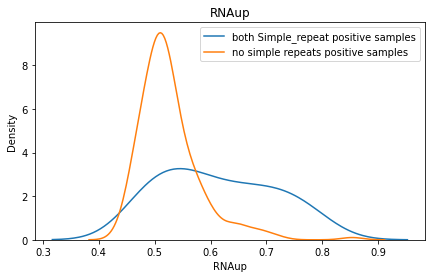

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.4775664034
P-value: 1.22518e-05

Test di Mann-Whitney U:
Statistiche U: 4220.0
P-value: 1.05422e-05




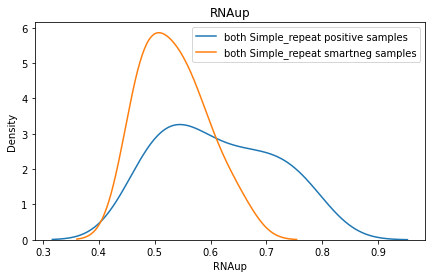

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.4071428571
P-value: 0.0567140893

Test di Mann-Whitney U:
Statistiche U: 309.5
P-value: 0.0116408426




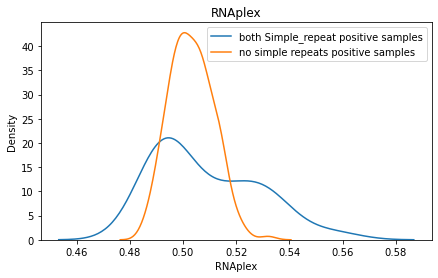

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3225053841
P-value: 0.0089018949

Test di Mann-Whitney U:
Statistiche U: 2882.0
P-value: 0.7691285554




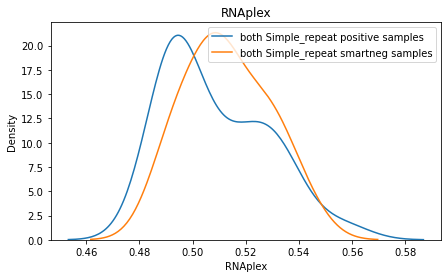

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.269047619
P-value: 0.3888529065

Test di Mann-Whitney U:
Statistiche U: 173.0
P-value: 0.3522979604




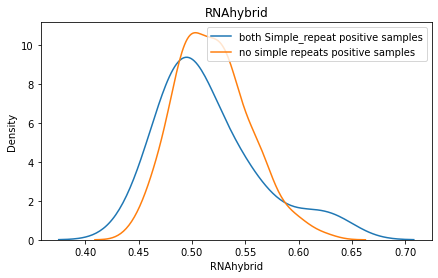

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.2090811199
P-value: 0.2002551433

Test di Mann-Whitney U:
Statistiche U: 2386.5
P-value: 0.2200910716




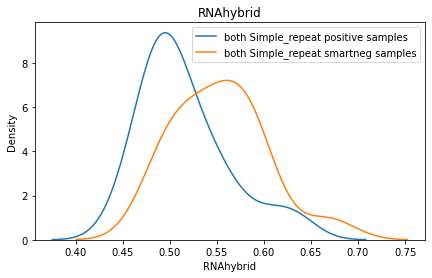

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.4476190476
P-value: 0.0270159921

Test di Mann-Whitney U:
Statistiche U: 109.0
P-value: 0.0104378225




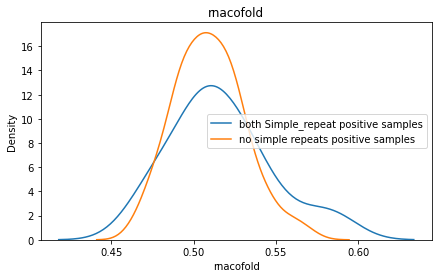

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1773151472
P-value: 0.3739527883

Test di Mann-Whitney U:
Statistiche U: 3115.5
P-value: 0.3119445603




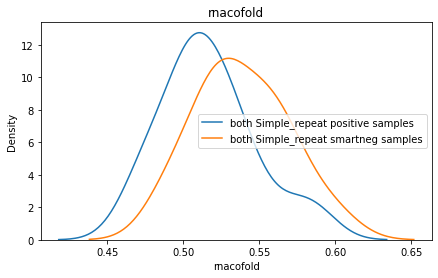

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.4380952381
P-value: 0.0328872071

Test di Mann-Whitney U:
Statistiche U: 125.0
P-value: 0.0312982989




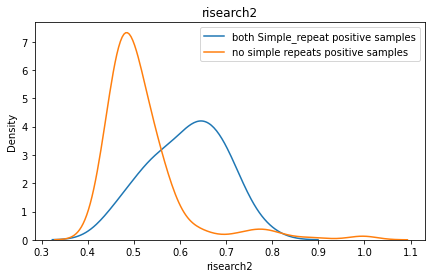

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.5857860732
P-value: 1.89e-08

Test di Mann-Whitney U:
Statistiche U: 4578.5
P-value: 3.64e-08




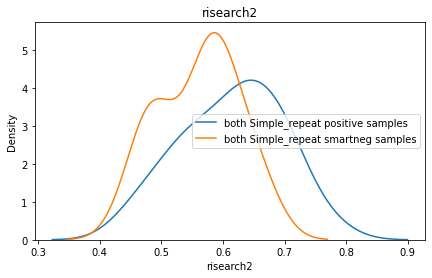

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.4071428571
P-value: 0.0567140893

Test di Mann-Whitney U:
Statistiche U: 292.0
P-value: 0.0378188861




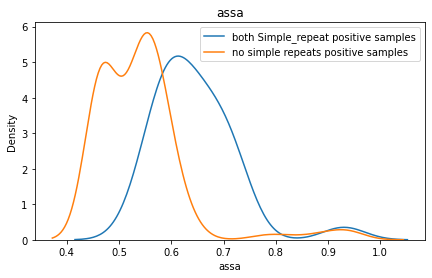

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.6968772434
P-value: 0.0

Test di Mann-Whitney U:
Statistiche U: 4950.0
P-value: 0.0




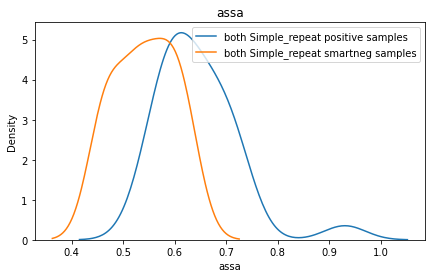

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.5714285714
P-value: 0.0017510129

Test di Mann-Whitney U:
Statistiche U: 365.0
P-value: 8.19886e-05




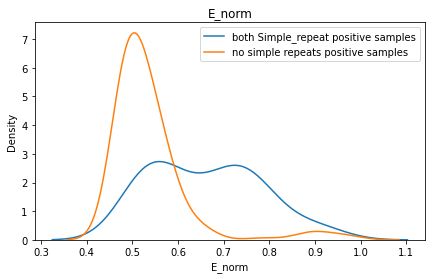

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.5423546303
P-value: 2.958e-07

Test di Mann-Whitney U:
Statistiche U: 4665.0
P-value: 7.8e-09




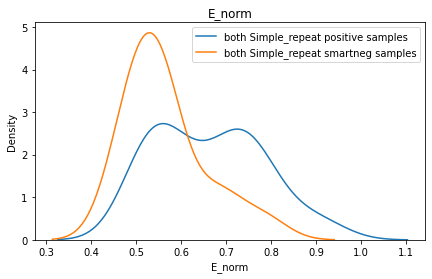

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.4428571429
P-value: 0.0300741342

Test di Mann-Whitney U:
Statistiche U: 315.0
P-value: 0.0077468919





           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  recall  -  -  - 


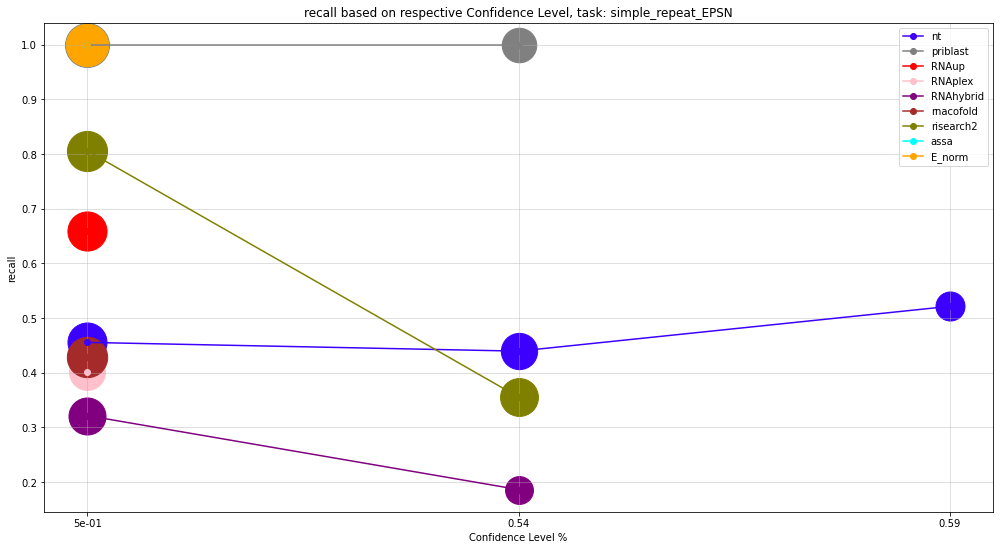

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  recall  -  -  - 


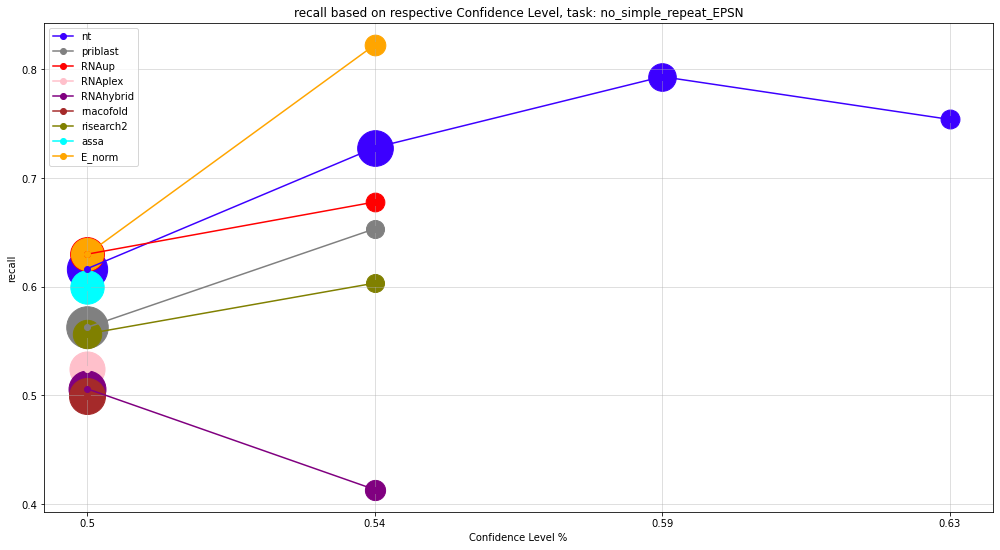

           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


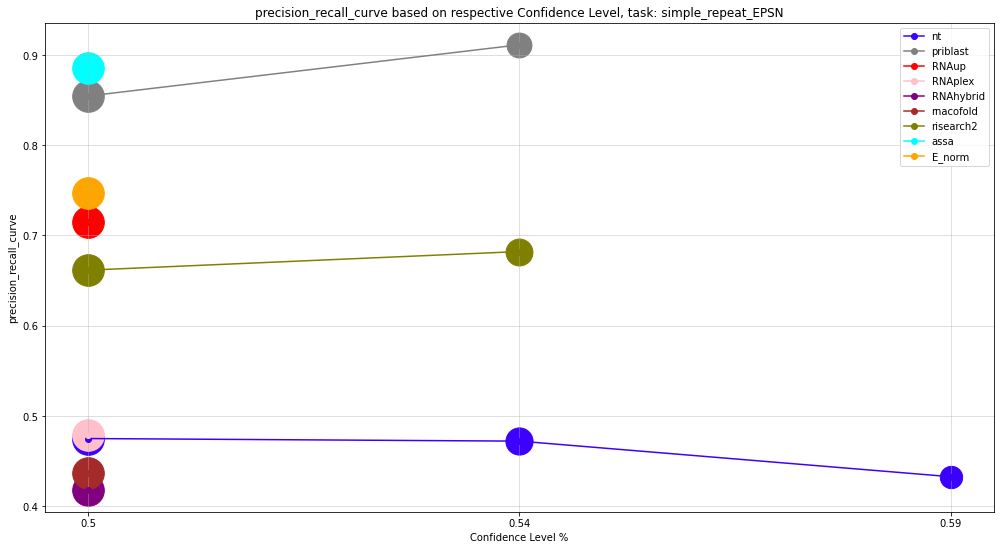

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


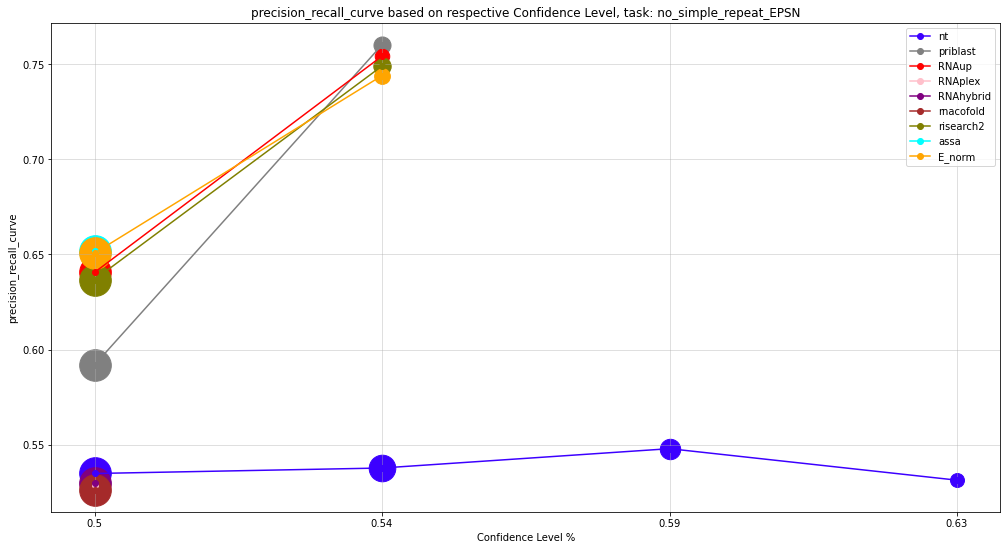




EASYPOS Percentage of SR in positive predictions based on model Confidence Levels


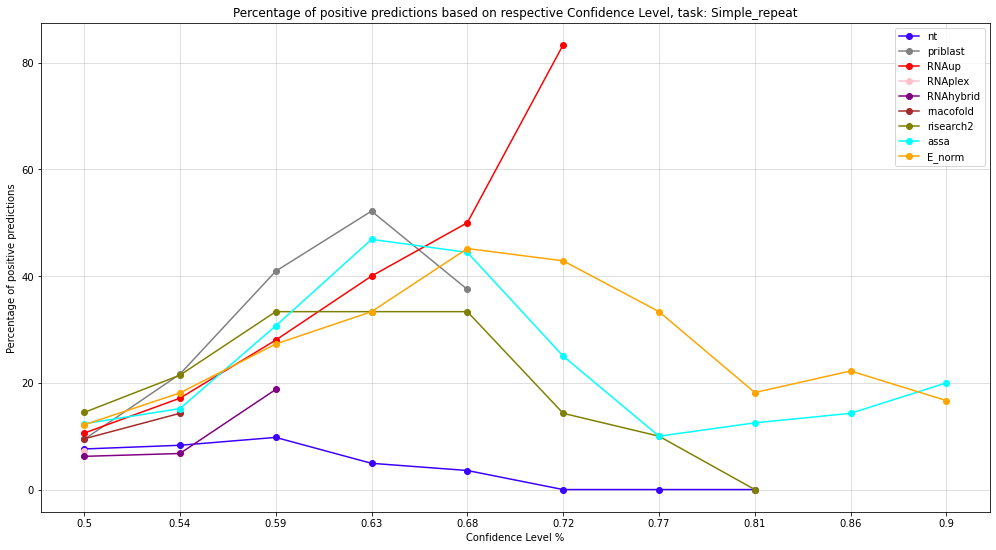

SMARTNEG Percentage of SR in positive predictions based on model Confidence Levels


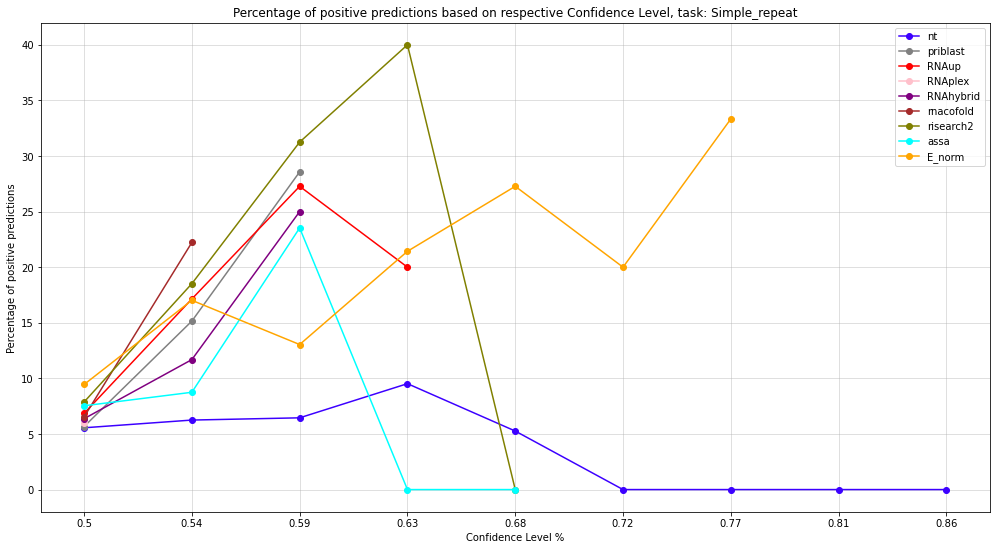




##############   ##############   ##############   ##############   ##############
---------- DATASET: mario ----------
# excluded couples:  4
Simple_repeat are the 1.0526315789473684  % of the total couples
No Simple_repeat are the 80.26315789473685  % of the total couples


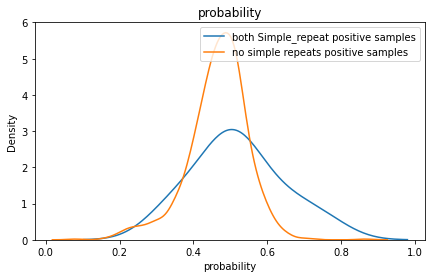

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.272007913
P-value: 0.2884623134

Test di Mann-Whitney U:
Statistiche U: 7686.0
P-value: 0.1114569235




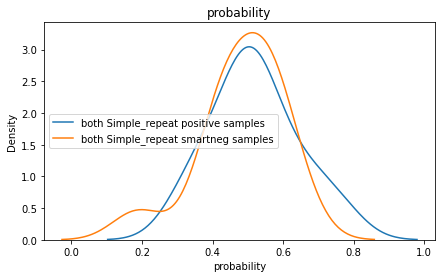

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1666666667
P-value: 0.9984852945

Test di Mann-Whitney U:
Statistiche U: 79.0
P-value: 0.7074539677




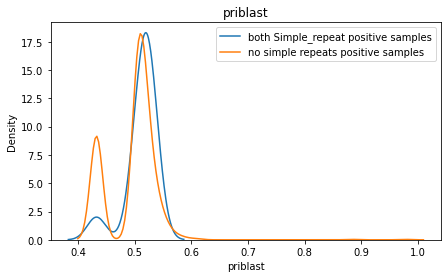

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3639960435
P-value: 0.0648379622

Test di Mann-Whitney U:
Statistiche U: 7879.0
P-value: 0.0725493928




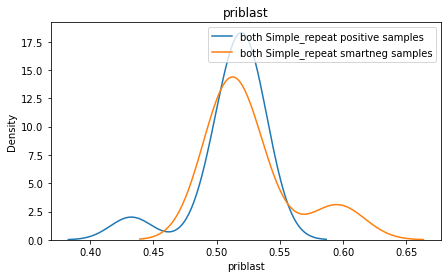

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1666666667
P-value: 0.9984852945

Test di Mann-Whitney U:
Statistiche U: 74.0
P-value: 0.9309874466




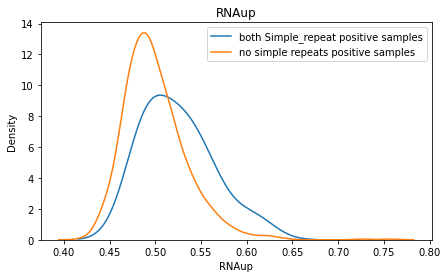

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3578140455
P-value: 0.0727819428

Test di Mann-Whitney U:
Statistiche U: 8472.0
P-value: 0.0180698635




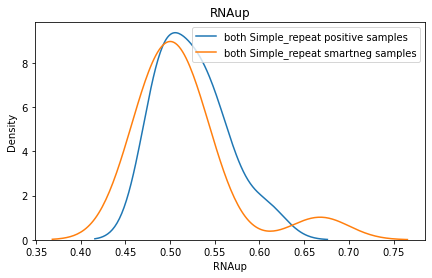

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3333333333
P-value: 0.5360977695

Test di Mann-Whitney U:
Statistiche U: 93.0
P-value: 0.2365840933




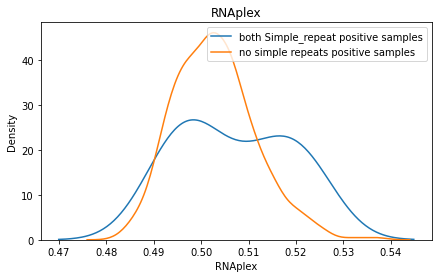

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3021760633
P-value: 0.1860215293

Test di Mann-Whitney U:
Statistiche U: 7204.0
P-value: 0.2635797083




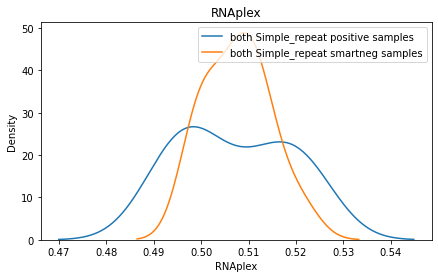

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.25
P-value: 0.8689816712

Test di Mann-Whitney U:
Statistiche U: 68.5
P-value: 0.8624606249




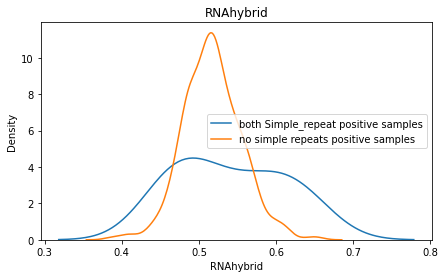

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3721562809
P-value: 0.0555150633

Test di Mann-Whitney U:
Statistiche U: 6974.5
P-value: 0.3721773445




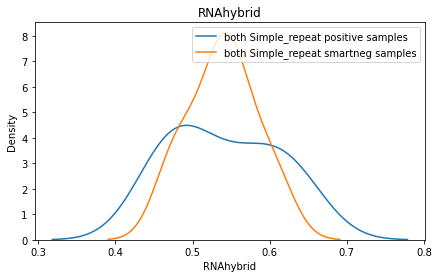

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.25
P-value: 0.8689816712

Test di Mann-Whitney U:
Statistiche U: 72.0
P-value: 1.0




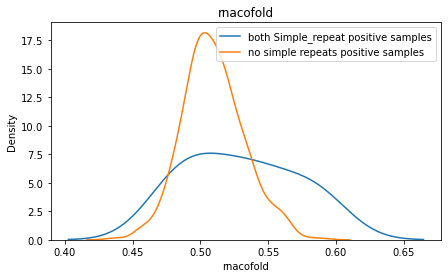

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.4208704253
P-value: 0.0203305613

Test di Mann-Whitney U:
Statistiche U: 7685.5
P-value: 0.1115671575




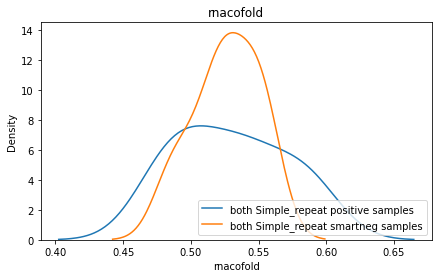

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.25
P-value: 0.8689816712

Test di Mann-Whitney U:
Statistiche U: 69.0
P-value: 0.8852339145




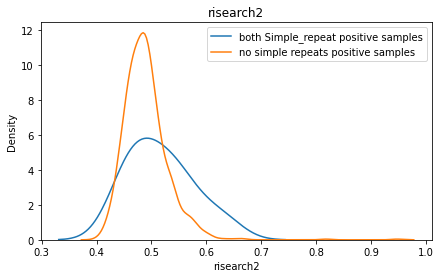

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3217111771
P-value: 0.1363779269

Test di Mann-Whitney U:
Statistiche U: 7663.0
P-value: 0.1166304163




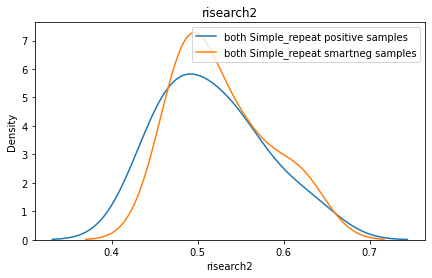

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.25
P-value: 0.8689816712

Test di Mann-Whitney U:
Statistiche U: 63.0
P-value: 0.6236048844




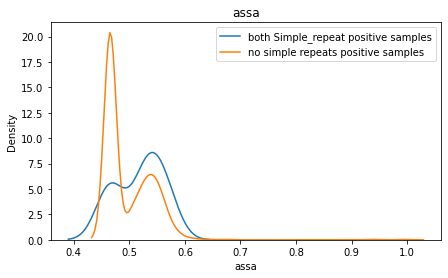

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3541048467
P-value: 0.0778514785

Test di Mann-Whitney U:
Statistiche U: 7803.5
P-value: 0.059340122




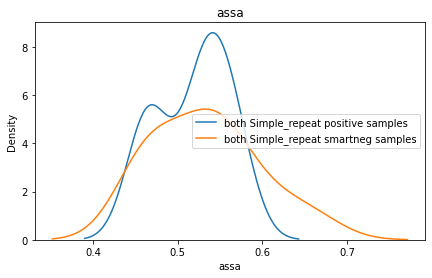

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1666666667
P-value: 0.9984852945

Test di Mann-Whitney U:
Statistiche U: 64.0
P-value: 0.6591092667




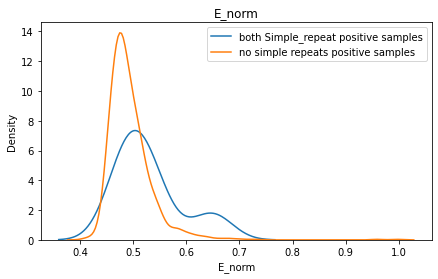

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3773491592
P-value: 0.0502526691

Test di Mann-Whitney U:
Statistiche U: 8634.0
P-value: 0.0116227314




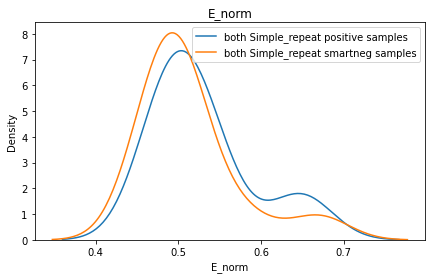

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.3333333333
P-value: 0.5360977695

Test di Mann-Whitney U:
Statistiche U: 87.0
P-value: 0.4025038238





           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  recall  -  -  - 


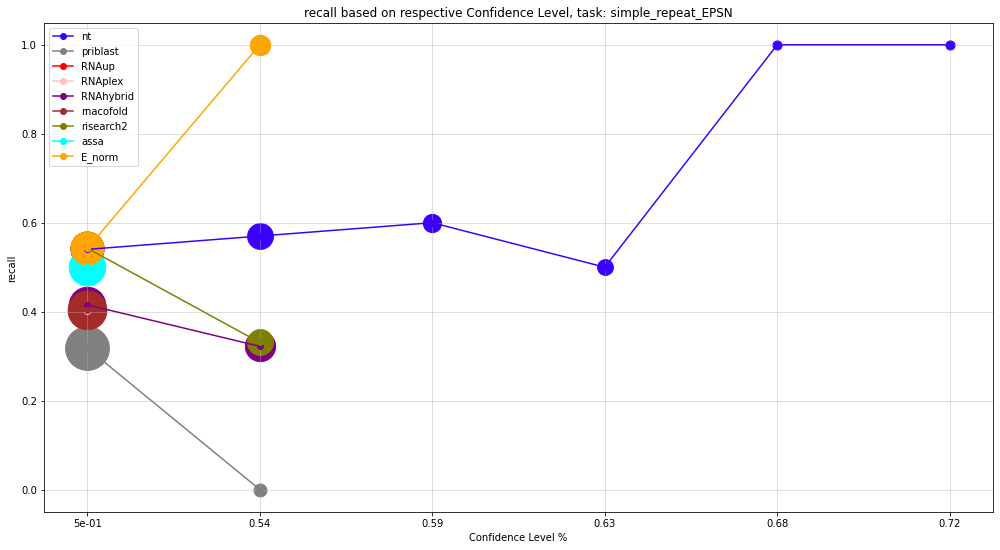

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  recall  -  -  - 


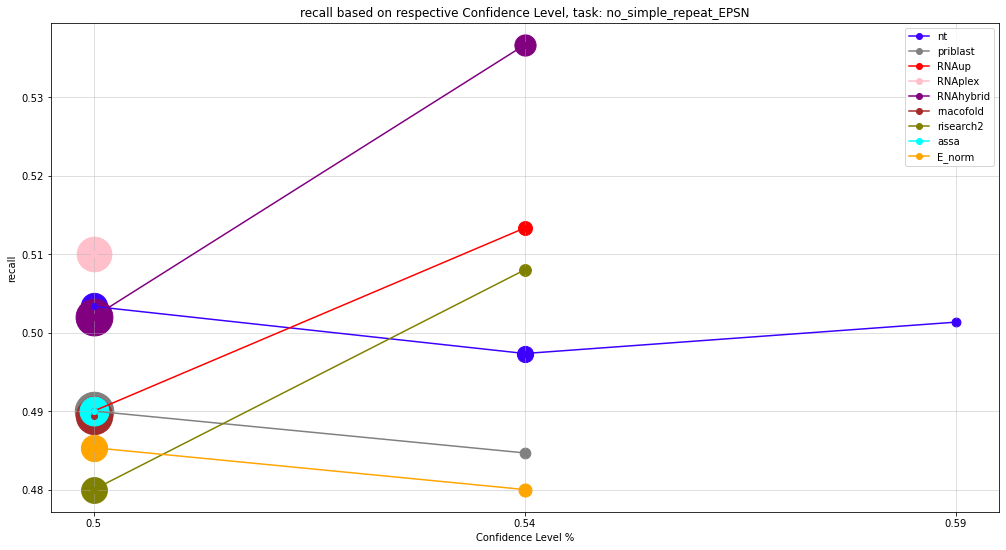

           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


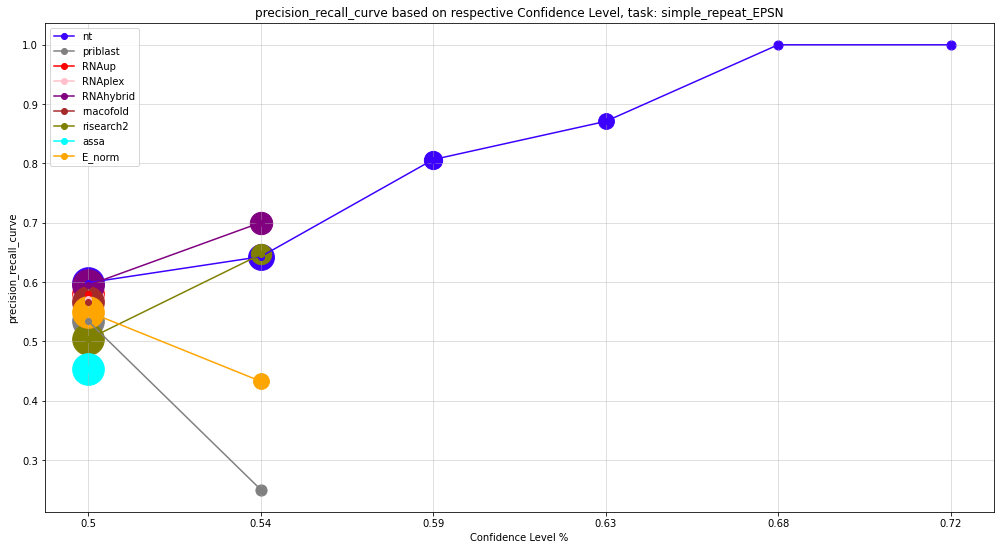

           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


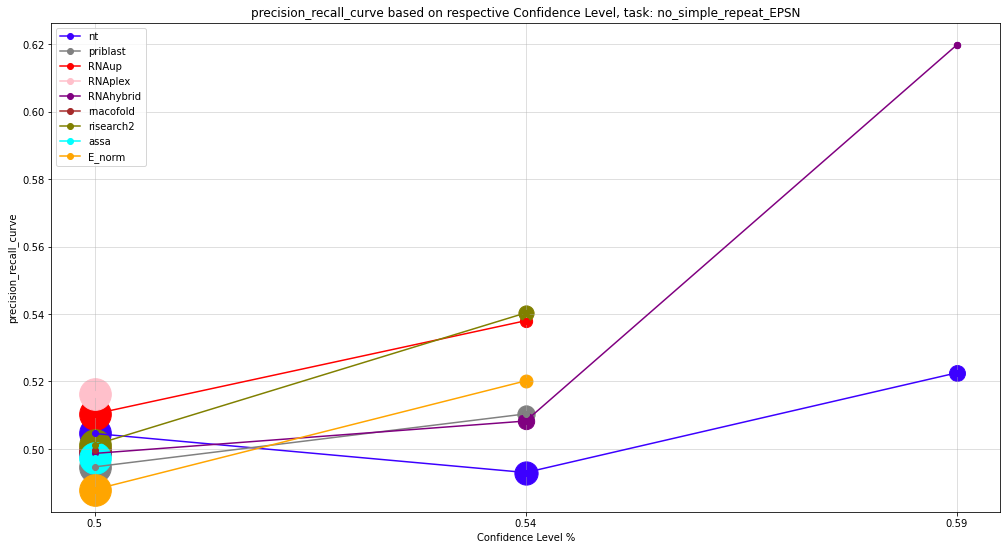




EASYPOS Percentage of SR in positive predictions based on model Confidence Levels


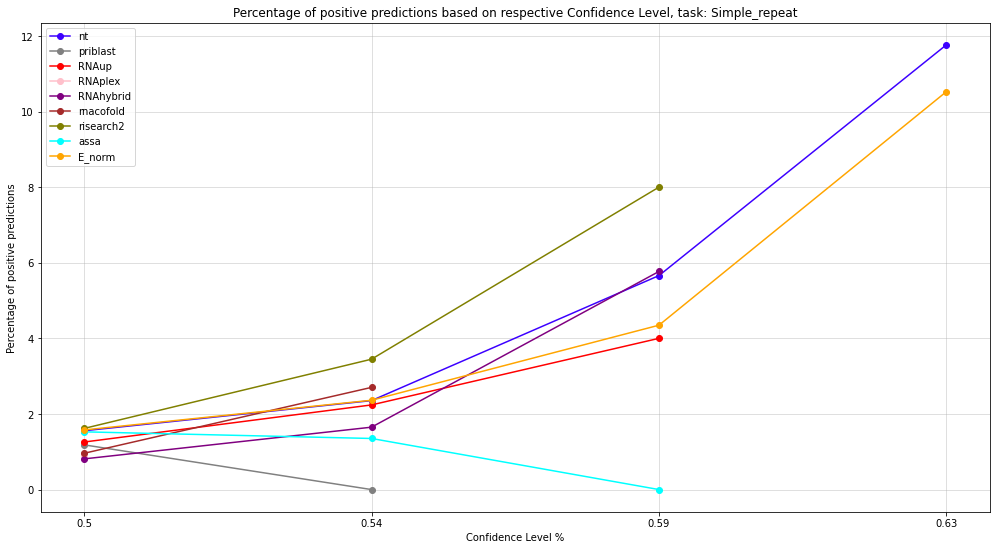

SMARTNEG Percentage of SR in positive predictions based on model Confidence Levels


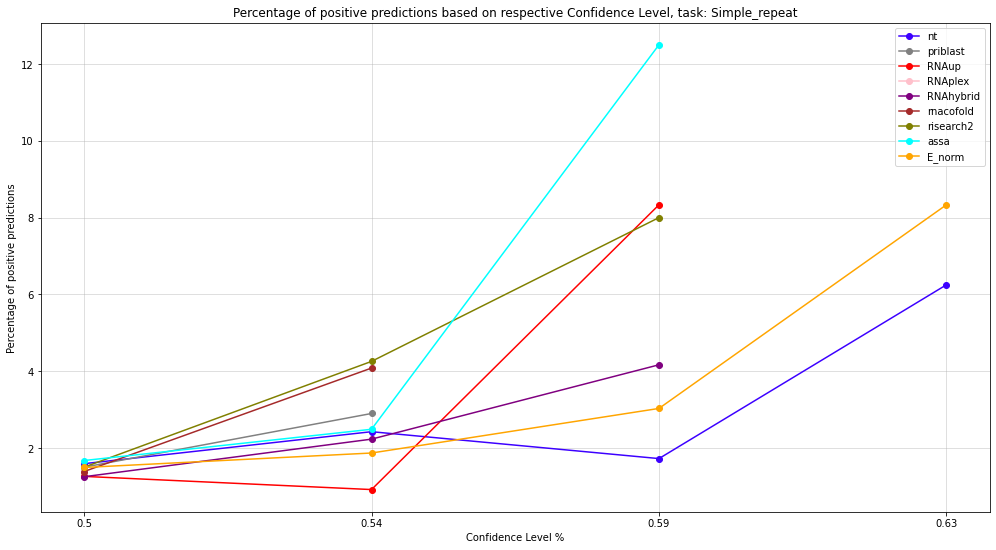

In [14]:
for dataset in datasets:
    print(f'##############   ##############   ##############   ##############   ##############')
    how = dataset if dataset != 'paris' else 'test'
    print(f'---------- DATASET: {dataset} ----------')


    res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             args_datasets[how]['MIN_N_READS_RICSEQ'], 
                             SPECIE_PARIS, 
                             args_datasets[how]['PARIS_HQ'],
                             args_datasets[how]['PARIS_HQ_THRESHOLD'],
                             False)
    #res = obtain_subset_from_task(res, 'interactors')

    for model_column in energy_columns:
        lrm_dict = logistic_regression_models[model_column]
        X_test = np.expand_dims(res[model_column], 1)
        y_pred = log_func(lrm_dict['intercept'], lrm_dict['coef'], X_test)
        res[model_column] = pd.Series(y_pred.flatten()) #modify column according to the model mapping
        

    test500 = pd.read_csv(os.path.join(metadata_dir, f'{how}500.csv'))

    sr1 = set(test500[test500[f'{suffix}feature1'].apply(lambda x: feature_to_search in x)].couples)
    sr2 = set(test500[test500[f'{suffix}feature2'].apply(lambda x: feature_to_search in x)].couples)

    none1 = set(test500[test500[f'{suffix}feature1'].apply(lambda x: 'None' in x)].couples)
    none2 = set(test500[test500[f'{suffix}feature2'].apply(lambda x: 'None' in x)].couples)

    res['simple_repeat1'] = res.id_sample.isin(sr1)
    res['simple_repeat2'] = res.id_sample.isin(sr2)
    res['none1'] = res.id_sample.isin(none1)
    res['none2'] = res.id_sample.isin(none2)


    filtered_policies = ['easypos', 'smartneg']
    sr, no_sr = obtain_sr_nosr(res, both_sr_condition, filtered_policies)
    N_total_couples = len(set(res[res.policy.isin(filtered_policies)].id_sample))
    print(f'{feature_to_search} are the {len(set(sr.id_sample)) /  N_total_couples * 100}  % of the total couples')
    print(f'No {feature_to_search} are the {len(set(no_sr.id_sample)) /  N_total_couples * 100}  % of the total couples')


    sr_ep = sr[sr.policy == 'easypos'].reset_index(drop = True)
    sr_sn = sr[sr.policy == 'smartneg'].reset_index(drop = True)

    no_sr_ep = no_sr[no_sr.policy == 'easypos'].reset_index(drop = True)
    no_sr_sn = no_sr[no_sr.policy == 'smartneg'].reset_index(drop = True)
    
    ##################### ##################### KDE PLOTS ##################### #####################
    
    for column in ['probability'] + energy_columns:

        if both_sr_condition:
            label_x = f'both {feature_to_search} positive samples'
        else:
            label_x = f'at least {feature_to_search} positive samples'

        x, y = sr_ep[column], no_sr_ep[column]

        make_plot_kde_and_test_difference(x, y, label_x, 'no simple repeats positive samples', column, figsize_kde)

        if both_sr_condition:
            label_x = f'both {feature_to_search} positive samples'
            label_y = f'both {feature_to_search} smartneg samples'
        else:
            label_x = f'at least {feature_to_search} positive samples'
            label_y = f'at least {feature_to_search} smartneg samples'

        x, y = sr_ep[column], sr_sn[column]

        make_plot_kde_and_test_difference(x, y, label_x, label_y, column, figsize_kde)
        
    print('\n\n')
    ##################### ##################### TRESHOLD PLOTS ##################### #####################
        
    for metric in list_of_metrics:
    
        for task in tasks_treshold:
            print(f'           -- -- -- {task} -- -- -- ')
            print(f'           -  -  -  {metric}  -  -  - ')

            if task == 'simple_repeat_EPSN':
                assert len(sr.ground_truth.value_counts().index) == 2
                subset_to_plot = balance_df(sr).reset_index(drop = True)
            elif task == 'no_simple_repeat_EPSN':
                assert len(no_sr.ground_truth.value_counts().index) == 2
                subset_to_plot = balance_df(no_sr).reset_index(drop = True)

            plt.figure(figsize=figsize_treshold)
            plot_function(subset_to_plot, MIN_PERC = MIN_PERC, 
                          list_of_models_to_test = list_of_models_to_test, 
                          n_values = n_values, n_run_undersampling = n_run_undersampling, 
                          metric = metric, task_name = task, 
                          size_multiplier = size_multiplier, balance_at_each_step = balance_at_each_step
                         )
            plt.show()
            
    print('\n\n')
    ##################### ##################### REPEATS IN POSITIVE PREDICTIONS ##################### #####################
    #Percentage of SR in positive predictions based on model Confidence Levels (questo prende in considerazione tutti i positivi, e vediamo se all aumentare del livello di confidenza predilige le repeats)
    print('EASYPOS Percentage of SR in positive predictions based on model Confidence Levels')
    plt.figure(figsize=figsize_treshold)
    plot_results_how_many_repeats_in_pred_pos_for_all_models(res[res.policy == 'easypos'].reset_index(drop = True),
                                                             MIN_PERC, list_of_models_to_test, n_values = n_values, both_sr = both_sr_condition, feature_to_search = feature_to_search
                                                            )
    print('SMARTNEG Percentage of SR in positive predictions based on model Confidence Levels')
    plt.figure(figsize=figsize_treshold)
    plot_results_how_many_repeats_in_pred_pos_for_all_models(res[res.policy == 'smartneg'].reset_index(drop = True),
                                                             MIN_PERC, list_of_models_to_test, n_values = n_values, both_sr = both_sr_condition, feature_to_search = feature_to_search
                                                            ) #these are errors
    
    
    print('\n\n')

# TODO

Aggiungi:

- TNR rispetto alla distanza della regione di interazione nei negativi in patches500 e in patches.
- AUC based on the interaction length window treshold (non so se e meglio farlo solo rispetto alla precision. Forse no perche in realta anche gli smartneg hanno una regione di interazione piu grande). 
- Mouse Paris
- Analisi protein coding genes
- Unire paris e splash nel test set?
- Metti piu modelli di NT in comparazione in questo notebook

Devo verificare la dipendenza dei risultati in basse alle lunghezze? (prime analisi dello script plot_results500)

Rendi le confidenze dei modelli piu alte, bisognerebbe avere un modello con slope maggiori (rank percentile)

NEL NOTEBOOK COMPARE_MODELS MI SONO CHIESTO: COME MAI IN MOLTI MODELLI (PRIMA DI OK_SN TRAINING) ALL AUMENTARE DELLA CONFIDENZA SCENDE LA PRECISIONRECALLCURVE DI SPLASH NELLE PATCHES? VERIFICA CHE QUESTA COSA SIA VERA PER QUEI MODELLI, TIPO all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0061parisHQSPLASHval0098 NEL NOTEBOOK plot_mario-ricseq_results500-RANDOM.ipynb POI VEDI SE E ANCORA VERA DOPO IL TRAINING OK_SN. E CERCA SOPRATTUTTO DI CAPIRE COME MAI. 

- Rendi i plot con undersampling (media di varie run) e non con oversampling iniziale.

In [ ]:
%load_ext autoreload
%autoreload 2
from util.plot_utils import plot_results_how_many_repeats_in_pred_pos_for_all_models

In [13]:
res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, 'test', how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ, SPECIE_PARIS)
easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
easypos_smartneg = balance_df(easypos_smartneg)


ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
ephnen = balance_df(ephnen)

# excluded couples:  56


In [14]:
def evaluate_threshold(df, model_column, threshold):
    mapped_signal = map_signal_to_sigmoid_range(df[model_column], threshold)
    mapped_signal = 1 - mapped_signal  # Invert for interpretation
    accuracy_gt_1 = ((mapped_signal < 0.5) & (df['ground_truth'] == 0)).mean()
    accuracy_lt_0 = ((mapped_signal >= 0.5) & (df['ground_truth'] == 1)).mean()
    total_accuracy = (accuracy_gt_1 + accuracy_lt_0) / 2  # Average accuracy
    return total_accuracy

In [15]:
df_s = easypos_smartneg.copy() 
#df_s = ephnen.copy()  

energy_columns = ['priblast', 'RNAup', 'RNAplex', 'RNAhybrid', 'rnacofold', 'risearch2', 'assa', 'E_norm']

best_thresholds = {}
for model_column in tqdm(energy_columns):
    best_accuracy = -1
    best_threshold = None
    min_treshold = df_s[model_column].mean() - (2 * df_s['assa'].std())
    max_treshold = df_s[model_column].mean() + (2 * df_s['assa'].std())
    max_treshold = min(0, max_treshold)
    # Define the range of potential threshold values
    potential_thresholds = np.linspace(min_treshold, max_treshold, 1_000)
    
    for threshold in potential_thresholds:
        accuracy = evaluate_threshold(df_s, model_column, threshold)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    best_thresholds[model_column] = best_threshold

  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
def custom_sigmoid(x, slope_at_origin=2):
    return 0.5 + 0.5 * np.tanh(x * slope_at_origin)

def map_signal_to_sigmoid_range(signal, threshold, slope_at_origin = 2):
    mapped_signal = custom_sigmoid((signal - threshold), slope_at_origin = slope_at_origin)
    return mapped_signal

def plot_histogram_01(data, bins = 50):

    # Plot histogram
    n, bins, patches = plt.hist(data, density=True, bins=bins, alpha=0)  # Plot without displaying

    # Get the maximum value in the histogram
    max_density = max(n)

    # Scale the y-values
    n_scaled = [val / max_density for val in n]

    # Plot the scaled histogram
    plt.bar(bins[:-1], n_scaled, width=bins[1]-bins[0], color = 'orange')


In [108]:
logistic_regression_models

{'priblast': {'intercept': -1.3729273603119811,
  'coef': -0.13055111465860883,
  'threshold_value': -10.52},
 'RNAup': {'intercept': -2.341296324685742,
  'coef': -0.21942916759378597,
  'threshold_value': -10.67},
 'RNAplex': {'intercept': -0.24903541088269093,
  'coef': -0.006645756105272504,
  'threshold_value': -37.47},
 'RNAhybrid': {'intercept': -0.75438522457696,
  'coef': -0.0031159363588686754,
  'threshold_value': -242.11},
 'rnacofold': {'intercept': -0.6501092692929774,
  'coef': -0.0018752864445753833,
  'threshold_value': -346.67},
 'risearch2': {'intercept': -1.7936333925752106,
  'coef': -0.04051979821861928,
  'threshold_value': -44.27},
 'assa': {'intercept': -0.775193436517752,
  'coef': -0.07405544876174112,
  'threshold_value': -10.47},
 'E_norm': {'intercept': -1.716455777935475,
  'coef': -1.2058447675680437,
  'threshold_value': -1.42}}

In [18]:
best_thresholds

{'priblast': -10.663736035234816,
 'RNAup': -11.763679926847502,
 'RNAplex': -50.284463224637825,
 'RNAhybrid': -218.89743005947864,
 'rnacofold': -328.28183975767047,
 'risearch2': -46.44063492593665,
 'assa': -14.423598985990882,
 'E_norm': -1.301451154072943}

In [19]:
slope_at_the_origins = {
    'priblast':0.1,
    'RNAup':0.5, 
    'RNAplex':0.1, 
    'RNAhybrid':0.03,
    'rnacofold':0.02,
    'risearch2':0.1, 
    'assa':0.2,
    'E_norm':2,
}

------- priblast -------


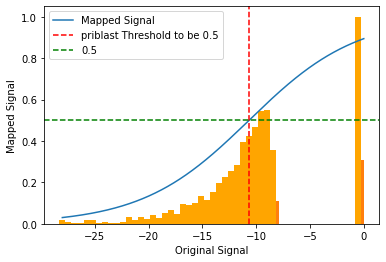

------- RNAup -------


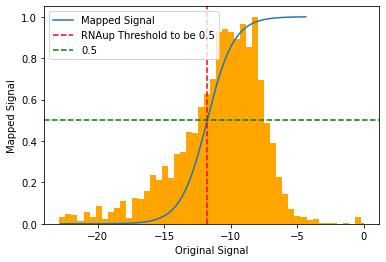

------- RNAplex -------


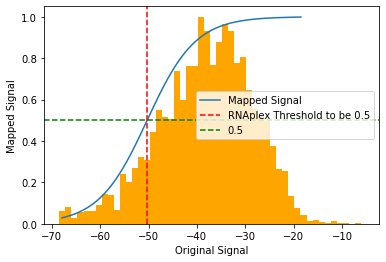

------- RNAhybrid -------


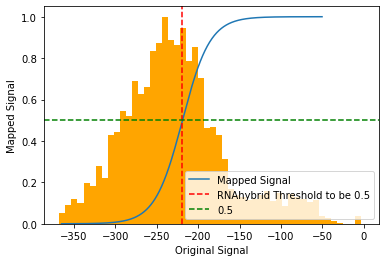

------- rnacofold -------


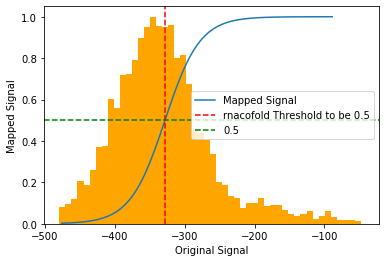

------- risearch2 -------


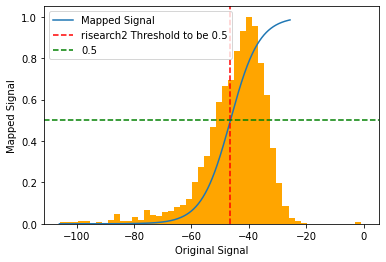

------- assa -------


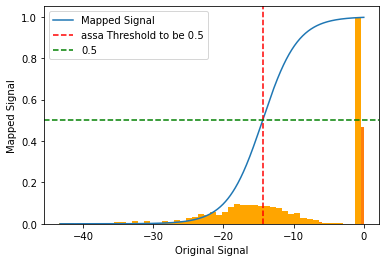

------- E_norm -------


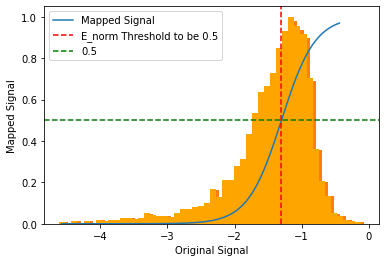

In [20]:
for tool_name in energy_columns:

    print(f'------- {tool_name} -------')
    treshold =  best_thresholds[tool_name]
    min_value_to_plot = res[tool_name].quantile(0.01)
    max_value_to_plot = res[tool_name].quantile(0.99)
    slope_at_origin = slope_at_the_origins[tool_name]

    # Example usage
    signal_range = np.linspace(min_value_to_plot, max_value_to_plot, 1000)


    mapped_signal = map_signal_to_sigmoid_range(signal_range,treshold, slope_at_origin = slope_at_origin)

    data_balanced = balance_df(res)
    data_balanced = data_balanced[data_balanced[tool_name]>min_value_to_plot].reset_index(drop = True)


    # Plotting the results
    plt.plot(signal_range, mapped_signal, label='Mapped Signal')
    plot_histogram_01(data_balanced[tool_name])

    #plt.hist(data_balanced[tool_name], density=True, bins=80) 
    plt.axvline(x=treshold, color='r', linestyle='--', label=f'{tool_name} Threshold to be 0.5')
    plt.axhline(y=0.5, color='g', linestyle='--', label='0.5')
    plt.xlabel('Original Signal')
    plt.ylabel('Mapped Signal')
    plt.legend()
    plt.show()